In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import string, math
from platemapping import plate_map as pm
from calciumflexanalysis import calcium_flex as cal

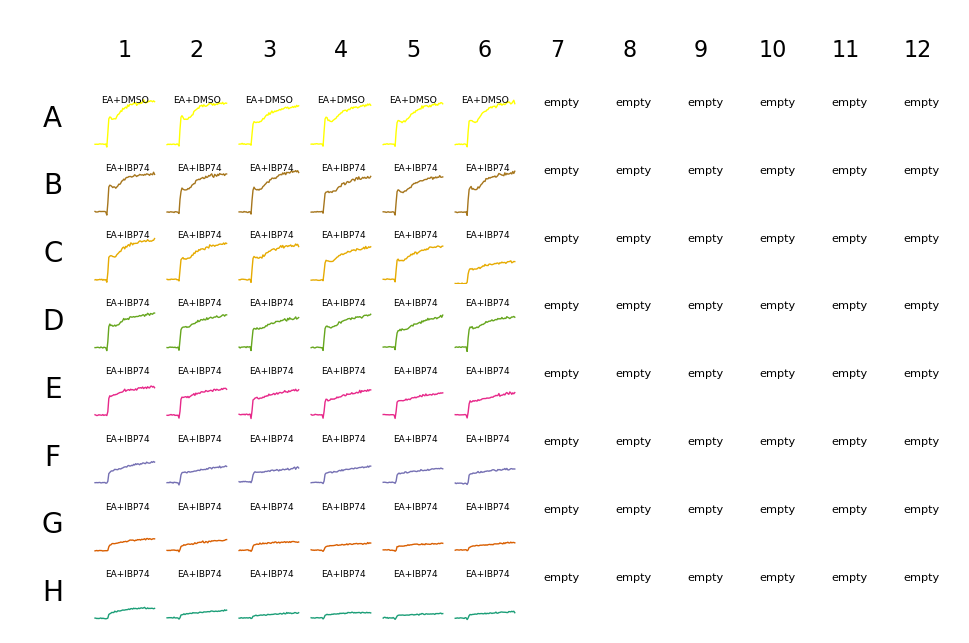

In [4]:
# text file to be read in (raw file from machine)
datafile = '291019 TPC4sYFP2 EA 30 nM act IBP74 inhib 3 nM to 3 uM.txt' 

# plate map csv file updated by user (either the 'short' or 'long' template)
mapcsv = 'EA 30 nM act IBP74 3nM to 3 uM.csv' 

# insert the 2 files into the 'CaFlexAnalysis' class
flex = cal.CaFlexAnalysis(raw_data = datafile, plate_map_file = mapcsv, data_type = 'new')
flex.visualise_assay(share_y=True, colorby = 'Concentration', labelby = 'Contents')


C:\Users\Lawrence\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


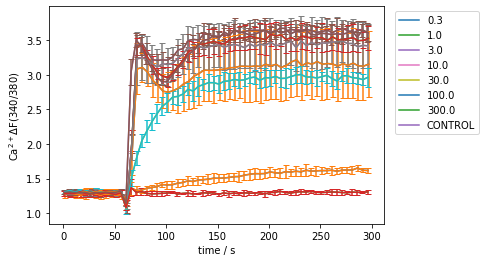

In [181]:
platemap = flex.plate_map
datadf = flex.processed_data['data']
timedf = flex.processed_data['time']
datamapped = platemap.join(datadf)
datamapped


# take means of each condition
plots = datamapped[datamapped.Valid == True].groupby('Concentration').mean()
# do the same for the control 
control = datamapped[datamapped['Type'].str.contains('assay control')].mean()
#remove unnecessary columns 
plots.drop(columns=['Column', 'Valid'], inplace = True)
control.drop(['Compound', 'Concentration', 'Concentration Units', 'Column', 'Valid'], inplace = True)
# join control and condition data series 
control = control.to_frame().transpose().rename(index={0:'CONTROL'})
joined = pd.concat([plots, control])

# generate std error and insert into dictionary
datamapped = flex.plate_map.join(flex.processed_data['data'])
# get valid items
plot_err = datamapped[datamapped.Valid == True]
control_err = plot_err[plot_err['Type'].str.contains('assay control')] 
# drop uneeded cols (stops error from script attempting to calculate std error on bool)
plot_err.drop(columns=['Column', 'Valid'], inplace = True)
control_err.drop(columns = ['Compound', 'Concentration', 'Concentration Units', 'Column', 'Valid'], inplace = True)
# calculate standard error, join and insert into dict
plot_err=plot_err.groupby('Concentration').std()
control_err = control_err.std()
control_err = control_err.to_frame().transpose().rename(index={0:'CONTROL'})
error = pd.concat([plot_err, control_err])
meansdict = {'error':error}


for key, val in flex.processed_data.items():
    # temporary dataframe containing series df joined to platemap df in order to groupby stipulated conditions
    datamapped = flex.plate_map.join(val)
    # take means for each condition
    plots = datamapped[datamapped.Valid == True].groupby('Concentration').mean()
    # do the same for control (cannot groupby more than one column in this case)
    control = datamapped[datamapped['Type'].str.contains('assay control')].mean()
    # remove unnecessary columns
    plots.drop(columns=['Column', 'Valid'], inplace = True)
    control.drop(['Compound', 'Concentration', 'Concentration Units', 'Column', 'Valid'], inplace = True)
    # join control and condition series
    control = control.to_frame().transpose().rename(index={0:'CONTROL'})
    joined = pd.concat([plots, control])
    # update dictionary 
    meansdict[key] = joined

    

# plot series for each condition and control
for i in range(len(meansdict['time'])):
    plt.plot(meansdict['time'].iloc[i], meansdict['data'].iloc[i], label = meansdict['data'].index[i])
    plt.errorbar(meansdict['time'].iloc[i], meansdict['data'].iloc[i], yerr=meansdict['error'].iloc[i], capsize = 3) # add caps on or off option
    # add label function that concatenates conc w/ the correct units 
    plt.legend(loc = "upper right", bbox_to_anchor = (1.3, 1.0))
    plt.xlabel("time / s")data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAeYAAAEGCAYAAACw1zZNAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4xLjMsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy+AADFEAAAgAElEQVR4nOydd3gU1frHPzNb03uv9F4UEEGliNeOFVTEBtZ7RbFwFa9eBfWnomIFLyoaRRERLAhKN4BU6UlICKmkJ5tet83M749NNj2EXpzP8+TRnT075+zMMt/zvuc97ysoioKKioqKiorKuYF4tgegoqKioqKi0ogqzCoqKioqKucQqjCrqKioqKicQ6jCrKKioqKicg6hCrOKioqKiso5hPZsD+BU4O/vr0RHR5/tYaioqKicV+zdu7dYUZSAsz0OleZcEMIcHR3Nnj17zvYwVFRUVM4rBEE4erbHoNIa1ZWtoqKioqJyDqEKs4qKioqKyjmEKswqKioqKirnEBfEGrOKioqKyull7969gVqtdiHQH9WoOxlkIMFutz80ZMiQorYaqMKsoqKionJMtFrtwuDg4D4BAQFloiiqRRZOEFmWBZPJ1LegoGAhcFNbbdRZj4qKiopKZ+gfEBBQqYryySGKohIQEFCBw/PQdpszOB4VFRUVlfMXURXlU0P9dWxXf1VhVlFRUVFROYdQ15hVVFTOeWJjY9m8eXOr46NHj2bs2LFnYUQqZ4vly5d7zpgxI1KWZe65557iN954o6Dp+2+//XbAwoULA0RRxM3NTfrss8+ODhkyxHy2xnsiCIpy/nsmhg4dqqiZv1RULnxiYmIAmDJlSrttOiviJyP2F8pEQRCEvYqiDO1M24MHD2YOGjSo+HSPqSPsdjtdunTpv3bt2iNdu3a1DRo0qM93332X3lR4S0tLRV9fXxlg8eLFXgsWLAj8888/U87eqNvm4MGD/oMGDYpu6z3VYlZROYfZvmwxO5YvaXV8xIRJjJw4+Yz2a/EPxRoQ2qrtyYjR6RC4sWPHMnbs2GOKeFvtti9bzI4Fc9m3YG6zti2vt6E4D4+k1saAoV+PExqzSufYtGmTW1RUlKVv375WgNtuu610+fLl3kOGDHFazQ2iDFBdXa0RBOFsDPWkUIVZReUcZuTEyYycOJmls2cCcOcrb53U+Tor9B312xmrtbN0VkTPFBb/UKr6tDYgLf7NJyQN1+ftWS8D8NysV4+rn/Pd4v738oMRRwqqXE/lOXsGe9S+M2FQdkdtsrOz9WFhYdaG1+Hh4dZdu3a5t2z35ptvBnzyySdBNptNXL9+ffKpHOeZQBVmFZVzlOYPbyMAs2bN6vTDu92H/2PPUrRlLeAQ3EXzP2LdoRTWHZrlbKM35WIozne+nnvnjYBDwDvbT1t0ZuwdTR5OlI6EsCkNE4UTEdz2+tCb8hgzZnSzic+5NiE5X2hr6VUQhFYHX3jhBdMLL7xgWrBgge8rr7wS8tNPP2WeifGdKlRhVlE5R2n68DYdzSBKsB6XxdzRw39pvTAD3Pf4kwDNxKg9kbH4h0J1Zqf7aXqs4Zwtz6s35WEozgNg7pofAYcIZyfGA47JQ0uxbtquMy79zoyxPY5X1Fver7YmPgBdA3zB1cP5ur0JSVuc7qWMY3Esy/Z0ERkZac3NzdU3vM7JydGHhoba2mv/8MMPl/773/+OPDOjO3Wowqyicg7Q2Yf/qeun0QJvq58GkXl3yl0AzIj53vleSyEzfTyP4vnzubT+ddKctwHwf/xxcHdztmtvXXbEhElsPeTwNja1UBvc6NC+63j7ssVOa77lOU8VHYn67s2xx/x8WxOftiYaFv9QrG240duipWv978Lo0aNrMjMzjYcPH9ZHR0fbfvrpJ9/FixenN20THx9vGDBggAVg6dKlXlFRUZazM9oTRxVmFZVjcDKBUJ1dSzwei27R/I9IN5W2OmfXAF+nCACsnzGduOw05+sGK/OyiG7sd/cCHCJh+ngexf/8F+Pr2yV9vwyoF9YWmD6ex6Xz5zva1QtwQ9sfcxxG1GNz5rB92WJ+b8PCbUmD5bf10Mttvt+y7/H1Y2sYow9w3+OP80dpDtB8LTy5yXVrz+LuXlDKpYVlzb5PW9/7VNKeZdzg7m7Ljd5w7PJ+vdixfAn7kvY0C1A72xb0mUKn0zF37tysa6+9tqckSdx9993FQ4cONT/11FOhw4YNq5k8eXLFe++9F/jnn396arVaxcvLy/7VV19lnO1xHy/qdikVlU7SNBDqeMU6MzMTaO7SPVa7YwVqdWSBNW27Zfd+AGa+/a7zeGc+OzCiG+Gr1rU6nnPZSNL8/bkuL5/cm65p1/3aliW8dPZMsjMzkaN6Nk4K6oW+gYT+/TjUv3W2wtHsQI/Cn7UDmZRf1G7f3QtKGTnhblbVW+tNJzmdvWYN424Qwvb6iCkp6tT5Wt6vtr43OCYFDedsr+/gISNIqW3tvT2RwLHzbbvUhYS6XUpFpRMcT6RsR1G5x7J6O7vVpqGPDx97AJvFTER0dLtrzD0KyvA5mNbquP/lZWxp8xOt+3nnvokA/HvRMud775bchSJJ3KG4EPXNIgB2xsTA4cPNPrt09kyy0tKQgqMYNewidixfwo7lS9DUn2funTfSvaCUgYVlDATYcbCZZf5FdibgmDz0ASZSL6LWap7rkcx297vZsdxxzXQcZjnA8iXOteiCxAS8BS09bp/IjuVLSN26xvkd5q750SmkbX3vt56b4ey7gQYLvsEKbSmQqcG+BAT7QEljcaD27pfp43kk9e7TyiNR2L8Xu111SMFRzfpm1svNztdyMrN92WIK2hBsdavWhYMqzCoXPCfrTo6Nja1fi+14XbaztCXqHQU3taTB2mp40K+I3UBqsC8M6tas3YgJk+gzcTLUC0/TPpoKZmfdoC3HuByg/vNtfb+mYt0gPG0dc1yEGR323XDOd6c0ThTSp05hXcN6eZ+hlAEZh1LoOupqTFuaW/qpwb6kbl3T4ffu6PqE9+3fbNwNbZu2g9b3a/uyxezYuqbNe1OYGA9prSdTx6KjSZjKhYEqzCoXPG0JbnsRwm2JbUdbaJoG/xyPuLakIwt898b1zfto50Hf1HK8//tf2uyjR0FZaxfqwdcxFRz7od6e9bhj+RI8/ANata8uE9DIAYglCis//Bq90Ui5CQTFs/G71J9LV/+ZuXfeSLhLOTl13o2ilybAmtYTgIb78uFjD2CtrSHQanN+76XFec2E1PTsnRT/Fuf87JEgH6dV39D3jqOHndexqYUKzQPRGq5Fw0QBmgfHNb1fx5qknAgBT0zjj9Kctic4KhcEqjCr/C05me0zbXGs9cW2ApFaWlsDI7oxvn5Nt8HdCdAtKozDof5A+w/62NhYkpQUp+X4xuMPO/chNxW9ERMmkT3p5rYf6vcdey/yyImT2b1xfWshnD2TiqpqAIpzivjlnY+oKHBsd8IGR7Y35ngQAG2Fn/O7LHnleXLTTeDmx53THyesVySiKDpET5aYMaYWpvzmuHa/r2w2nvKCEhS7G6Ligk2oRpZlRLF1bZ6AuUv5w7P+mgWGM/Pd953jbnYtYt8E5X8QBbAaZn0IQD+GkoVvs3OaPp7HDTsOOu5X7z4UewaSFRiB6KZBoJaCxFy+HX8vUYVZBEX6kOWqa/xw7JvcqfwPuta/nvW547+jT0ysVS4sVGFWUTkBWrqTAa5vq2GDNdpk21BH1tbb7i8j19YyKb/Iuaa75sF/ItRUYcqyUJpnwje0tXU6duxYirasbRSZ+Y4H/Xf/nUl+ZgmKmw8DhwyjrNBCSZ7dYckWSyx/4xNErQZR1KBRHOf9cc6n2C0WrKYM3O16dBqZKt9UmOWI5B7u3ps/a5tsDY19k/H2GHa5D6G0LJtFM/6Jotjw8wjBZKlECorgsRkvUFddx7rPPqEkpwDKk/h9/nfUVVWSn5KHIJWBtYgfZk0DQY9OccfbZsTNbGPxj0bsP9+PEBKMaPMBRWaFYsE+aQKK3FiboAL48N578Q3rg9UsgHKMx1sb4lgY70FS3jCyAkKRBYHe2Sl41ZZR3N8DWuS5CnhiGov27kOwGxGlCiS5AihHq/EkwOhFuUWm0LWCwi4eaDTuaGRPZGv9pGHsCyzeWEHe0SykoCBmvvs+po/nUfTP+fSI6E+5mysxt9yPoIDNzQVR44dgsmO1WNEb9Khc2KjCrKJyAgQ8MY2AJ6a1Chxqdw31GFZ4UytaQ+P6rZ9HKHK1I/mGpbqcmKcfxMPmS6SmFlyanCD2TcbbviLVvytHK2W+fOA+qqx27FIVoCBY84nfkNi8UxscPdg6t3/mvqxWx9bm+rKl+gGumHQvu5bOA2oAKM0vZuM2D7KOXAZYgRoE0Y1xDz5H8vafIa0cRPAO9sMb0OplFNEIkpakLd8BIOqCQBOJ3dONgf0vpigzgwpTFhU1+VTopMZBlJfXXx0tkqABQdNkhDq0mkCMXp4UZ+0FxYaIiGteIT8/cgcDPFPp4+rT3Ood+wJLt1SQlZoB7pEE+/hRbIxHjqwASgGBbT0CCIi+EYQqyEsFQJZlEmL3sOOn5VBXhIKIVhNAt5FXM/jq0fz04SwKa2sIrCvnqre+YN/vsaTu2YJiy0Kbr+XbF99BAApSkxEFPbLdIdZFgy8jdmQClpocoGHCoYCE468Y5j1wD31G3YYsn/+7aVTaRxVmFZXTRFvu7aYRwoLiiiAZyU/NaTO4KeOaiexd+SkgIGhDQSpHUWqo0hVzCBBtPoj5Vcx/+AmsdWXItoZdLxYEUYurqw8hgkKYSwkhxiIMogWDaKZa40W4eBStKGOXRSRFQ1pNV7YU96fGWgVKHQg6fEIHUl5sQrFVg1xKXUUG6xbMQtAGIYq+lIsQ89RUoKFmgBa0fij2QjYufA1wFHwXjx5m7p03YjB4YbFUATIa0RNZ0aIoVnoFmDlUUonsYuDKqbezbelqKmKP4lCjpij1f7XICuhdQgn2iyLStpddxV7Y7Ll4Wau4t/tWNtVczWGTF2a5mvSKWtIrQhFENzQaH8Rimc+nzcRcU4q1rgxRqYPSJIpKtbj7dQfCqKzKR/YJItjojSlzJwD+Ll5E1CQz/977sNrLEQQDER4ejA34iwBDMZQth6XNPQphPSMJ63k/S2cnkZ0iIEh1FKY6lgwEjS+KVIHWVMYXT71Mef4+BNENxasvdk+Jme/OZc+qLWz+5h0QfUCpRZFrSdz0LaAjyNWNGzU/NLrBweEKH/vCyf94z1EmTpwYvXHjRi8/Pz97SkrKoZbvy7LM1KlTI/744w8vo9Eof/nll5mXX3557dkY68mgCrNKm5zvSfZPFScTydzRVhsXvQbMNShKEd+9OI3IAVdxw5ON69xxiidH6kVZdI/EbisiULIx5qUP2LZsBflHdoJcBtYyzM6U/gKIHuASzNQ5/8U7wIels2eyPc2OZOjHzDmOddWNs2eyLC0NyT+cSw1VHDIZMVdlAsUI2iAujvLi0v98hNHd1TFRUCSi63zJ0laDYkOxlwB27A29atwwuoVTYy5ECvJk0v3/Ye2nn1FlOgSCq2NcSg1WmxW9W1cstkrMQV489NQLfPvCv0nKq0TUByKWCcybch+KVI1G74ugj0QBegZIWAMvwlaUhr08n2CXCgZ7HsLf8CcAO6t7YxHt6DWh5FblEcOdeAV6IImpSMHhTPnXWxzYsJXD22KxmwvAJlMjeaMzeiPqFBTJA0XnxsVX/QO/0GD2r/uZyioJRS9x/9svUZCey7LX36a0JpPSOgWNRqL3FXcx9r5b+WT6g3yVezF35KcStd6xX3zXYw/Q4FHIT83h0OZdFKZXIdhMgIybby+sdRXY6gpAcAF7EeX5jm1XilyDUJGIrqIh9kCDRvBgdEI8epuFHP8oUkKDsAilmGrLickcxf0jzfg/sbxzP+jznKlTpxZPnz69aMqUKV3aen/ZsmVe6enpxszMzITY2Fi3f/3rX5FxcXGHz/Q4TxZVmFVasX3ZYvYtX4JHi+MjJkxi5AUuyutnTKe0PltW02xVXQvLqPDqjlknYqemVUTv3Da2DYFDnLMT45u5t8uLyvjq2adBsYAhAi9vH7Li1/DpY9sQtb4ossQRWyYgcMW9M9ixKgbq80lEDehO1IBnHXtbU/ORfIK47paJFKRlcmTXdqw1xSg1R/hi2hR8QgeiIICigAzZSZmU5hZSYcKxxpyXw16lDlHrTdehN5MatxmEcsb0qAX3JguqAlxSEc/ohav59Y3XqSjPBMBF9GCwv4lLfLZxWLyY1em+9WPsxiPz5hC38S82xHwOgsjQ6+5n+C3j+OWdV8hKywW88A8PZNLsN1n84rMo1lywgot3dwZfO57h48cwd6pjDX78gFqY8ikA7065i/wqIz2OeOG/3pGJcddjD4BQg7c5g/Ab/8mBtYswV+vQ6AKgRovVYmXs/bdQnr+PrJRicIvGx9WFsvxDjnsAIMG+VZ85v7IIiDl25j/8BJ5+oegMBqzWENAaCHQ1k3s4noVPxCJYbAjo+NVvIC5Pvoibtx+y2RONZKREr+W7Fx9zXELBSICrB+MC9xLmsgVZhl/LbiG9WEFBA0o1I+98iqz4DY7fin84riVV2Cyl+EZFsUFvcwatXQMs/u/zFKRXAnZ8Xf8+26Suu+666uTk5HYX2VesWOE9efLkElEUGTduXE1lZaX26NGjuqioqHbzaZ+LqMKs0oqmkb8F+QV4Dh/NlClTWD9jOnPbyRD1j3c/PAsjbU1HFX7aKpTQkn+8+yE5MTEUJh0iJCuV+7//BVmWmf/Q01hr0kB0R0ABWUNTV6vOGERVqRZJwiGE7ZCXksXSWf9Btpc7DljysdSKeIUMpsqUiWJpWN8VuOLuZ7jkxtEOYW72JeuDlhp2TG35lIFAaPhQVqf5oHj2Icjdm+Kje0GxIqJFzE1xBFY5EUAfxhVdLQz970JErYZ37mud5aspgVHBPPTpPD656zouPZSNi02izFNkzaARFOg0yIoVRbaTHr+VwjXzqDy0i551WnQedjRbtzFvRTRQL3rZKc7JjH9UNMU5Fdi9XfnnvJPb+jNu6m1EDezDr+/9H4o1C7GU+u8tIIjuiLIE5UmUVRjwDR2AJFkoK81E9gnl5rvup7KklP1rV1NTXoWiEZElG0WZu0Gpd0vYIL9ORKM3Y3T3xy7pQZFBMlNVepSKwgQcvws9Go0P3S65hl4jh7H3t0XkZKTzjXQtM2e9jwhYZs9EqmgU4e0//I+A6F6gKOiLrdgsBYy84ymyEja0+p5arYCsKUYKDKeNIPTTzn+3/TcitSz1lJZ97O7Tvfa1y147qeIY+fn5uujoaKcPKSQkxKoKs8oFw/Zli8lJTACgdM2PHSbZ157iQgsnQ0fboE40oceKuV9irUlD0EVgDXVzBnUteWUmOenZiC6hKJZSEv74BhARURCz8/js8efxCgylvEhBVPwQ86tZ8tK/ABBFTwKqNZh1GmqqKjFXZdO4Vquhnz6cS24eC7FvMj3458bB1EdGJzCU1em+zbb+HJo9E4Q0ZBc79895kdqqWr5+9nmUknx0ioJP/yFEXHw5Sds2YCrIRApy4ZLobNA2DaLqmD/+9xJjD2SSGKGlxMuNML0HIX9l0s2iIAmgCEew/L4Bb8AbIzUGcLNoyRjsz6OffY27lx9vzXgawDnu7MSZSKIJ2Rh+zP5lpZaAimz26q0cee8ZPKK6IdnLHZ6BeroP7UNIjzByMwQU9xAGXTSM8oICClIPY5ckJHdPpn/wGnqjgaWzZ1JWZkfRy/QeORCAjH1rqKw0IQWE8+y785BlmcUvvkhRjgm7jzfPDjqM9sGvAZwxAbcXOVzZsizz0WOPYKurwL8mi/FPPQDA/tVCq+/iRIRbZ77ED7OfpSQ7F40YiGI5SuSAaxlx+1VtCrNK27RTFvIsjOTkUIVZpU0aXLAtEy0AzSKRO0rUcS6vRXeU0KPpnuNN3/xK+p5f0BojscpFQOO2J1EEBCs2b4Wrb/gX6z99B0Vy7OVFrqSqOJGq4qbxKQ4BDO0zjkmznq5/qJu5Q3EhaMFSjix6h7y4fVzsnUCgYRPM+hZwrKH+WRRJYHU59//kSF5xaPZMoO2sUYqtnLVvPo64eRdjMh1rnZIAmsQjlK1ZijbaAwxuKErrbVcdEfv5bII+/JHDEVrSQroTVF3NDd+tx2qp5ZuZU5COpoFOT48rr8K3R38i+1/Kgjlz8Sg6yNjdhey67Sr6Lvym7TErMoqtEmhc128wBOeucSQY6dO7B1fEpeBmAUUA/WerAbgOx5QmPURk0+ezEIzh5B0+hAAIljJnNLqHfwAVVdVI7i5o9TokyY4sy46+FbnVmBoQRRG9UUGUDtP9cBVbNAYut9SiN7Q2GEVRRBDt0EktaOg7ok80IyY8xo5lHwIlCLpQbp/5z86d5Cxwspbt6SI0NNSWmZnpdHXn5+frIyMjzytrGc6wMAuCYAS2AIb6vpcrivJKizYPAO8AufWH5imKsvBMjlOlNe1laRoxYRKzZs26IAu+m0U/9q76AqNHFL6h7uRkmlo3UkBXorDuk9mIWg+8wwZSWpyNYAjG06ihsigFaKg6JxHWZxx3zXoaYt9kRtTqxvO8s4KBQLWhO1/nXtRuMNH2ZYvZsew7vOos9KqsxfVIJpuHDUExKvjLFiLMMj6OpuSHGtk1LIBCwRXZrwsj+odQu3YDAw6ZGCJVUOmSx7oDItbYqxBCgzBYc7FqDVRY9Hi1+Jrxrja6vPc92T28yAztjlDXWElvz68/U55XA7pgAPb9sQ/+2MeICTYEQaQ66CIqX+uKz2ufkHnHnQiX9EdxCUWWZeJjl2OPj2VMaiUeZlh960iCHvsXTy/5lbdnPgeyxL/7HmZdViiRS9dQ6C3wZ78IJuYXkD7xATJX/oar1Ya72UpISTVuc5diE0W6RriRHuCJ3ieYiy4dTEX8fmz79zPAZMGzNoHkVY5c2oPr/8rcklg392lG/+u1Vre4JD8Dcfc6rk2to9oI7llWdu0ajv3+W1FoX9BbImNHqM1h/XvPYklKwic5i77FEmXuSWz77j1G3PUUB9avxVxVgjXAnZ0/f+/8N9fS/Q8gKzV45u3B1scdXQf9/p246aabyj/55JPAhx9+uDQ2NtbNw8NDOt/c2HDmLWYLcKWiKNWCIOiArYIgrFYUZWeLdksVRZnWxudVzhCmj+cxcMkKZ8EBcCTQaDfx/nmIbJcQakGskzi4YRd+4UEERIYAIJpFqqVyNHpvJv/fa6xd8Hazz9ZW1VJTKaKRPFCqk/EKGsgdV7njuW8OeDbpw0dgY821xBf6ohhcuOPl6Y43xr7Au4sOOrZGNRHh7VPuomHtuulkSCsrYJao/OAjrqitwaNOQhagxFPA5mnA5mqgWoZcQabKy5PrX3gLY1IGJcuXOP6R52WzNy8bBE9yroikpiID/1oLgXV1eKcU4L07l671XsCcPbB/ySCqe4WjM5cjKArRRyRyu3hw+be/kfz8szRONhq9K3mpKbj4h/DY+/Oc723Z5Sg8MWLiExyO6kndE89yzeY49vfMYNvlg/AvtTNIECj0cqfAS0dkSgWG6f/HloD30PQNx+4SxLrl2USnZ5J2SRiJGk8ESYMoFDHu0afh0aeJiYmhIm4v/eL/pPzZF8hb+i1d9mTT+2gVkAvr9+ItQL6/htQQA7UebkR06w6iQFFmOua6OkLLzPT4fA17flhP1cAwFMUdgG1L3kP77kJ61yls6u9OeeSljHbZg3WnmdD3lzHUW+BgFx9MOplQq5ndK37EXlaMCBTrDPzvlmsIqKzF217NtSVm9BLwRwJWjUiFi4EsPz0BVbV4vPo5sQuX4DK0HzV1NaDxdnp1AKf7/+nXXmPX0o9x2baam7KsyEBSX8Hx7/RvwPjx47vs3LnTo6ysTBsUFDRw5syZeTabTQB47rnnTHfccUfFb7/95hUVFdXfxcVFXrhwYeZZHvIJcUaFWXEsANT7+tDV/6k75c9BAp6YxrrCHPKPFmEP8XWKcNzsmSeUeP900NGWrjaRQVMq8d1/36UsPxNzdR5ifVDPhs8PNmvasOoqWS0kfv0il9RsR2fsTWlhER/cPQlJqsbx09Uy0E9knPd8xH2t135FoHT2TCRTGpJfFKIoOgVXwOHxXO4b1lgMQipiWHIBJXUKrrNf52oZRBmnW9eig7x+gdSMHc2OpHxErTsz332f7csWc6hhzdwOP732BuBw39ZUVjYTzKWzZ1JRayG3Rzj39jsCU37DZjXz/kO3Icq19DVWIpQaCf4rg25mxz/PrEAY+d0q4tataSY8DelEG6jJy2x3O1nvS66h6Mcu7L7ndi5JqiK7pzf2B64mN7sCU2Y2Lv4hXPXa62z77FVcl67jxs0p2DSOBChJA7uQYRbQCI771XDNwvv0h6hejnsmiFx83X1cfN19fPvSk5Sl7karN3LFw9PpNuRKDr3zBgX1KTkHDB5aP+nxBI0nKX4KpYY6ehWUctmfWRR6CRSWpOO7ykx+qJFDVw6gurAOQdQysrsv8msr2bH0A2zzv+Ca/Y7a2MmDLkL21tDDBWqMIiGlNoLqY/wKfEX29HChLCCEu2e+SXCX/oiiyFsznkaR7QwJ1eD77TqGrtrFXz1dKPJxI/XgZmqKC6krM2EoPYRnZQVxIy8hoE5B9BTY3N+dsrD+vBBWxN+FlStXdlhbWRRFvvnmm9YZcs4zzvgasyAIGmAv0B2YryjKrjaa3S4IwijgCPC0oiit1jMEQXgEeAQgMjKy5dsqp4DSvDoEqwlN1fGtRZ4pjjfftTanCqUmhXyTBr1rMAHRQzFVVqEYtYwaPY6ywiKqSkrIToxHkSXcFTOPfPc1SdsO8NNHBUANiCLuPuH4hEZRUZhDeXkOe10D+MervwIQ/8oMFOUAmmobNqsZnd5IP2U3d3atL/M463NGAiP7ONaOdxSGc1tBOuFrdrPu//7JdbvzKfAWyIwQMfTuDxoNhcUmrHV1YLdyX8w6Brt7A7Cr3orqKE93dmI8NZWVx7yWOr0RATcU0Y3rL3ODKb8hSXbmPngTGls11xdX4OEd6MyVLddUcVtBusGCQDgAACAASURBVNPSB1jwtMPJ1dRibopznIGRpPgrSBoRNu7FKyAMD59eaLQ6XN29cYsYws6oZELLqgmqrCE10IdKQWTEhEmkZ5mpKitldPwG+q5Y2+691ulcsetC0fmF0P+KW1q939QabRj3A+87Ar2+fPI2Iven0C/DTMbtw7jqpQWY3n6VksLGCakoilw26RneWbuTA9HF9Kyrg8gB2CrrsJolBAUqhCwqB4WSW1hBrcHhbBYqYcl//uO8PwCCqOXqGe8T6/0RJV8uZsThSoTDu7Ct3YUe0APXArIAhZ5uJIZ4Yo6OpKq6BkHnDfx9hPnvwhkXZkVRJGCwIAjewM+CIPRXFCWhSZOVwBJFUSyCIDwGfA1c2cZ5PgM+Axg6dKhqdZ8G7FaHVSiWJhO38S8GjrvkbA/phNn58jsoNSl42AMYkfgXWuUIAMn9+nJkQD8uuXmMs21DtSKD1Ub6vmRWz/s/BNGIrPXEHuTLo+++Azgsz7LyGsSaWlbPehDhQBK90ssYXL9ZY/flQym/eigmuQerc+qt6H5H6msLNwiphV+8ghk0YjjRlbUc6KInK6Ard+VnEjV3KeAQnvJDcYSkJ+BaL8pNaUtkBo4c0Uysm1qyLVk6ayY5SQmtgq0ANIiAJ797e/J7vXUs6wzYPH35QZIQj6NsZMM4Fzw9Da3giktgEOnFOVS5eYAggizx9n0TuXz8LTzzw28seP55yq01PDYwA6asojA1l9iEL7FpJX4fNAr/1DwCu4e22ZeiiHj49kERzG2+3xZNJzjxYdEcClWQUkspe+M1aksVvIMGY9dqmJcajPTSW8haESVyMBbBzgGhfq25YXFeAYSeRLkEM/bey+g5sh+fPfskQJuufoCxDz3J0tw8ElL24CrY6Tv2Klx8A3DxCWTTD8sQtW48/uHnzYLjxOwU5mY3Vt/qzH1QOfc5a1HZiqKUC4KwCcdkMKHJ8ZImzT4H5pzhoanUI9srELQhKHIt6z+fg6vna8iygqgEIJadP1sQrBYruzKTQHSjNNofT9chRH2zCNPH82D+fHodSmxWzenuflUEDKgipy6MH95+CYChkRZ2FdgBXzIP7eDImh/Q74jlH7kWjPWhJQXBBpJ6elKk1yG7ejIovZguy3cRBRR5upJXaGLhYS2RV2Vw33sf8OvqjdTs28BFexLwqYJDof7keXiitdiauWpLkxLQ0dp13DQID5pv9TqWWDd7qJPAiAmTiNsTB04hdFRzenvWy8jVVUw6uImQFTvYuGQNu7MOIgsKBEQyuv9ILr2tc9H3kl0ibv1fWN0jKdDUgrkKL49QugdFU5KWRJGLHrHrEPqPal0OxFpr5ofvliIgEF2npcCgEPPtV0xuY6KRvieZPNmTSh8zWsWLdTG/4mKoJCcxoVkQFYj0GnELNvdIbIJM3JESPPpehVxnRpQV7BqRKp2dFNEGASAqdtwVDS6igl22U1NZBLKMKNnR2qyINgsDho0m7eAeMJuJ9IgkybeU7zf8iH/sBtz14SBbObzlIEr9Cp6nxo9qqXmCEFHwQvAPYfTUl5zHtv2yETh2FTOVC4MzHZUdANjqRdkFuIoWwisIQoiiKPn1L28Cks7kGFUclP78f6CY6eFexsU+CSzNHMCvc/+LIBpBqgArxG38i+rSlHb3Ax/rQXE60n62tz8ZgMBBoGkMWgp4YhoxJUWtqjm9/+h9uMalYxV8EMU6ogQbhYkmIu12gpIPUbdqDRFAobfIgS5GSoJCGXLpdexb54j0RQKq4GBAIMqtt2HNOoj/xgNcfLQ+ZW/qYooXLGZk/TjK3ECaP5sJV97RTAgb9sV+8+nXKOlZjEiKpdeqTc7xt+U6jtu+o9n1qKuoQecSjYBC/1HXN4r18883E2HJJnFkfy6y0Z+EUgOl33zD7lVLnUU11na/koq33qNGtBIq+qGrLsGq07L+0J/EHznE+FtvavM+6ABRNLBw+suUeRmpEa24CwaiLK5c+8AkQnpFOL9LQK0POW46vv/iW6bOeKzZ+X75fBklciXdPCOoqdzPdek5rOs3nEXLFxPhE4IFsGsM/Pq/H9hfkIiLoCeiTMLq4c72o/twxUB4rzEUZuzELSCKLgPHsD8zgT3lWXgIBtxkHRpRg0WUsLqImGUregUivEMJDwkl//Ae8jMSMPr58djAjHqvR8uYVfD2c0NWrMj2GgYn/cZ1K3aw5/ft/JW4j0wXh/We+UeTfeku4C77s+Lj+aRubYzSb2+tvtmEq+k9VEX5guJMW8whwNf168wi8IOiKKsEQXgV2KMoyq/Ak4Ig3ATYcZR4eeAMj1EFyHK7EtjBkVo/Drlej3+QKxUFB1AkK+giwV5K7Nf/45+ff9rufuBj0dEa8YnScn/ynbffz/LXn8EzoA9lfhqo18b2qjldettd+Ocdplbwwm6Q6W0qxlWqQ5IkFEWh2EeP7c4r6XHNRAqXr6A4LQ3JK5yxD05j7IPTMFfX8dXr7yMKOiK696CwII9qzSAyrx2Evq4W17w0hLIcPLoGUyRXIldVcklZNTUlNubeeSNaQYubVyTrB9yC7YW3qNTL1AlWcIPMoWPwfXUu4b4hRHftgkYwIintu2rTdiXyy5qVVOvqUIAPP/mYAYE9ueKmcc42tTYXdn77O/tS46jWO86VVeUBVWl49h2FOy5INjN52hq8RT13XTmeHSl7sMQlc+2BbRQ+/gF/HNjKwqVfE+4SjUaysfWHDdisPvS/5mGy01Io0pqpEOwEad34x7Bx7FjzLRYUpyg3YJHKuHbIXfy2bwO/ftbowdhVNJjEujQuCRtIobYCcsC7/ChTHljAoq8XcbQ0jzBjBCuGhVJZmIiuvAixKIdyWYYCcHFxxxwYzhFXd4SI7lRo9eRl7sVb1nL9mJv4c+WXADz8euMEp2HSc/erjoIQS2fHojTJ9NbwO4uJicESt5frEraR+8iMZpPC5b5hMGUCIyZM4skXn+Hr518BQcMVt08EQUAA1v+8gio97C8xMeDySVx/3y18Pet5oHHCVVtejVEfAmg4vOUg3sG++ISdm3EfKqeGMx2VHQdc1Mbxl5v8/wvAhVse5TwhPzUTAK21DF12LhWigl+NlTJXPe4VKQRXVHEkxJ/fPlrErf9+qNlnz1QBjGNm75IVVn30AQhabv73U3wV84mz7ciJkxnpnwWb33IekxVYuTyNGk0UNQYdbt59GPXpSxzcuJI9Td2Hu44Qt+v/AMfs0sVUwsLpL2Nxc6NUZ0EyyoCVvOwD6NFicNGhkQTKPLXYvXrgrxlKl76DKS7NwJa4D2N1ImZtOIFDb+ZodQGVggQoeAoikR5B2Kw25JICfM0WTGEuJJrSiCs+Ap7u+ElB7Px5E4PGDcPFsyH5icDqhT/xV3Yc7qILkbUKsmLDI7w3B4uSObgwmRBdEKJG5r3cQOzCX4Tp/fGvErCY87kyUiLL71pyC/PIrzZh09gZWmzl2rnT0Rp07EjZU98LDL9lNH0vG8zv3/5CUoUjYDYzcavzUmm0Av6SG1ePv55uw/sCsHNN20lGAIbddDn5uXnsK0wkWhOArNGyrtZAmMGPa6bczKJ6rwaAf3QwDz76EF/+byFHDbW4y3ruGncrva8YBDT3KMiyTNz63fy5dTNGSeSGSRMJ7RMFwNZ6Ye7Mb6wmL5O5eQIj3Be38gi1JdZNg+Ms9S7r7pf2a74VTjQQFn4xCUoKae99RKAuCEk2s3HRb6TlZJBvKUFxUQBbM2tbb/TAU+8PdBiorHIeomb+UmmTkpwsQIfWVguKnUirBZ23gFgtYXI10KOwFDfRk/Q9q8hN/kezz54OS7gtOsretfXQy2iK7ZgrM+g3ZjKBUcG4yi7otR5IFNcP9AViMoOdD9H4oYPIk4qoMYhYwrpT5enKex9+QDfPcMJ7XU5uxm5c/UOJ6NmPuAO7kFzckF3cqDI4CiMb7HUE1epRKoswV+djt9cCinP91tVqpU+QB/usMmvjN6NTNLi7R7LkYn84GIsrBkI0vmiqyxiRuJFeq2IBR/CXpbCIQYe3EfXxfuxWG1lx6Wz68VfKdBJrDm5iw4EtdPeOxKgPoUKvY1dOHH19ujJ+yu1OC+yOp+6jJKuQP1fGEl90BEWj0FNjYOTNE4kc1M3hGsVOD+8Metx3AwBffvElloT9DEjeitbwBqaP53Hp/PmAw/mQ1LsPAFc+/jhVlXUIgsDtzz5H9Q/fUfHZAkduasC6/AuSAP/HHz/mfb3hodsxvVtMlmLCReuGAYU7pk5C00bqUK9gX3zC/PFJL+Tygyvp/up/2jynKIoMvmY4O9d8gwROUT4Wp8t13DQQDuDhd14kfU8yK39fSaarBdCRnb4bP9GToWH9KUqJR5bNjLr9HsqKy6gsqyAz5QiC3PkEJxcCtbW1wvDhw3tbrVZBkiRh/PjxZe+//35e0zZ1dXXChAkTusTHx7t6e3vbly1blt6rVy9re+c8F1GFWaUV25ctpjDNUVJPUex4mK2kebox4pZJVCbEQ3I6qcGB9DyaxP7IaFZ+8BEEuIJ4+gLCjnfPsmAGSo9g9IjC3Vfio3smUde1P8X6Gn6O7oX2wQexVxc62++S3DClllCnExGCe+NRlIuuohaNXxSZ5GEV7Ri7XEyNIFFQWAAhURjR4Wk34GKRuG7qZIJ7OHI9L3h6GgbXAKY3XfvdE4eMjSuC9nLZ/StJ332YP9ZsxCzXMbhc4uKpDxA+oAtff/015rgkjJbydq+FVq+j69BerFt8FFcz3Dp5Gvt27OFISSZWFzt6ReHm4ddw0XUjWn3WLzKIWx6/C9PzL6HY6rhrwGEYNLPdvgRRcBTtqCfgiWmscneDgnimBCc7g8QA7E9PAwW8Q33xfmoa4U9NI+bNZwCY8sJ7jSd9uuPcQRqdhrseuYf/fTifGsHK3d7FeAX7ttte0QlYLLno7HUdnvdcp+vQXvyrfxcWz3ofULhp2oP4hjtc1guedkzSeozs72zfMFH4O2E0GpWtW7cme3l5yRaLRRg2bFivjRs3VowbN855IT788EN/Ly8ve1ZWVsJnn33m88wzz4T/9ttv6Wdz3MeLKswqrRg5cTK7fl6FV3BPqrP2oGj0PLt0FeAoOCBo/akw1uJdZSfIL4zC4mQ02kFIfp0vhtARHYlwZmYm0NwK3705FmSFpG0HSPxzJ/kpcYjV2YDIDU88RUS/rhxOr6DCXEK01Z0SrY2yiAh6e11BScpfSCXxFAT6Y1XsuERchFSdjyRYuTnrL6K++BRbnZXlb35IuU1GLxgYfNkIIvt2wy8qkM+efRILOEW5M4iiSPfhffkzcRdyXDIXJW4jclDrVJCdQQC6Du1N16G9sdaa+e6Vt7FLFW2KclMkbI0lD89B3Pw88bLU4ScL9Ig++Weq6eN5FM+fT8M0Lmm1w9LvjAV/JtEZ9ZgtjrQNvuEB5824zxSiKOLl5SUDWK1WwW63Cy2LVKxatcp71qxZeQBTpkwpe/755yNlWUY8G2W4ThBVmFVaUV1aiSxV4R0cRkX2HpQWhrAs1CAIkBLqT3DSNkojLsZWnApevdo95/FYvMebOERTaIWyNH5Pdmwv0bmEgEcvZG9Xogf1YPXCn8ixmOjmGkZNaSq35JiIH3IFcSUZaL28MFYFI1vr8I4eztQ3XuTjx6c6z91yjbEW2JS2iRETJhHQ5dyKhNW7GjHbG5NNtPdQB5ocA+b0OakH/ekSDwkLkr3RImzPjR5+2UjSPF06PFfAE9McUfgnYMGfTToc9/PPn6VRwcZFSRGludWntOyjb5h77bj7+hyzOIbdbqd///59s7KyDPfff3/RlVde2cxtUFhYqO/SpYsVQKfT4e7uLhUWFmpDQkLsp3K8pxNVmFVacTQhFQD/iAgy9gqO5A9NUIRaRF0o+V7F9I8rQKzLYH+kK36Hsp0PS//HHwf3xkpMxyu2nWXP739CaQKCLphBV05i0NWX4x8e6Fx3TvhjH7ty4tCVmyhK3E1YWRX5pVX0/GsHgV4e7OzZBcVah49rNA/O+W+r87e1H7i9zFang/bECDiG4Dbeh1XVDouz6UM9JiamtTv6BB/0HYpH/bFTQVtu9Ia96OE0vz6n0qJsPfGgcTLT5Dd+puhoPAFPnLuTjFOFVqvl8OHDicXFxZobbrih2+7du43Dhg1zbk9op/TjeZWEShVmlVbkHXE8yBsKOshtrB3L7j4oZXlkBXgi+NaBSz/KyUT86gd6XTrA0egkBLczFGXms+Wbj0HjjT06lHFTb8P08TyS5s9nPFDjF8avig5fu4EJXfrwc9FBBmWXUOQtkHrDJRw1iSgWE6Ihiqtytp3WsXaG9kQ457KR5HT3arWm25YQnm5xPNUct1XfQgg7WvM+EUu4I+u/rUnBpXMcxU2O14I/GS+DcyLU1uTqDNEZy/Z04+/vL11++eVVK1eu9GoqzMHBwdaMjAx9t27dbDabjerqak1gYKDU0bnONVRhVmlFcXYWoMHVy1EmSa5fm9m+bLEzexKWRBBcyAwIZ0xiInFjy9CYjaz7bD49hs5HbCOCti22L1tMaf02p6bJQNpKHdkUu9XGstdfR5GtyJG9nb/khofWnOeew2D0B8HKXQ/eD7oqLv1iPslhWgKCR5JWUIVsr0Xj1gXFltdhX2eK9kRmZ/0D+EKkI2u7TeHpxGSvs6LXoQi34WVo2ffxWPBwbG+Gup58bPLy8rR6vV7x9/eXqqurhU2bNnnOmDGjoGmbG264ofzLL7/0u+qqq2piYmJ8RowYUXU+rS+DKswqbVBRlIvW4EdNhaNqjqxx/KhH+mcxss+fznbf59xAblUVZa5awrMTyQu9CmtFIuu//JFrHrmjU32NnDiZ5GorpqMZRAlW7nylcV9xcgcP4eVvzMNcdZTB1z7I3qP7m71nt9jw1AdRKFZx28gbCOwayqr7riJSgszgQaTZixA0Bm6Y/iprF72HUp9Ss+V6ctOqT6c63WFH66U53VtWQ74wOFPC01nX+ulwwXdkwZ+N8VxoZGdn6x544IEu9Ql/hJtvvrl00qRJFU899VTosGHDaiZPnlwxffr04ttvv71LZGRkfy8vL2np0qXnRjm840AVZpVWmKuKcPONoKLAMRGVNPWu7LEvsHRLhbPubtTFfcjdvJojQQFckppPmfYgZoOOhI3fkrCxMRFEgyXckPe56TEAY7c+oO/Y9ddejmAX99pmr7d8+y0Hk3Ip0dURXimw/ovZ7PugluHp+eztH4Vkr0Cn9eTOiL8IWncF5e692VHjiKg+VoKIY3E8wnMuWcdnag1VFR6Vk2X48OF1SUlJiS2Pf/DBB063l6urq7J69erzantUS1RhVmmGuboWyVaGmz2Cso8WQDD0OlrBitEjSW2yl7QmL5PEvEy0Bh9KvVyxi/m4aMq55t9fseKd5/CLuIQid0cQZNPEHzExMa2s45iYGGqOdpy9qEE033n+ZcSjh9AZfBh89RXOtJoAn0x5kNqI7tRpbURb3TDripn21ffsvHokqcE+FGq0CNpgrjHFEbTYUed312MPAFUd9t1ZwT1XI2iPRXtrlh2toV6oVr2KyrmAKswqzchKdEw0Q0eOpCLKD/bFktDbn+kxjbmLm0Ynb178G3t+/R/7u4ZwcXI+HgEQ0msM+cmxDM6TiTBlNKvcFH7ZSEwRYSc0toTNexGz0wCFW5//DxF9uzJq8v3ExMSgLZPJrsxHROHu6+9g/Y8ON/gfc54itFRiX/9gBI0HCKUYFWu7buuBEd24dNU6oHWUb5vrjscIMDrXInqPh3PJqldR+TuhCrNKM3IPO5ZjqktzyN++FsWox6PcwmePTkc0eqHV6FGMoejtCqvvnY5/ajxE+VLm4Yeg5LPnpWnc9PEvfP6vPcRH6tk3vC+TChsrN+2MiYFjWMcdVogS3VBC+hLRt6vzkLbITnptHt4adybfNxn/jBi6uSwgy6yjbHkAe7tHI2Ojl285KRWOn3xHbuuYfu1EuzZxtx63FX2CgUwqKip/P1RhVmmG6WgWIPCPh6awPO0IJr1AlpuH83094C5rqdLbye7mA91G4VZQiFKWw+7Bvbls92ESN33HkPH3svuXT9CVH38VnKY5sMVKBa0pC8lagl/kcIr0VtA51rxNH89j175M0qLcCTXruXTt95i+W4jy+OMsr32EwIPr8HbTUWbUEN73KtLy99PUbX0yAVjqeqmKisrpQhXmvzntBVXt/W05trpaJO9AAqw6rrz2BkK6h+MZ7MvXc2bgLsM1tzxJ0p4EEs17sZbnUOzqSXKvLvi9+T4XX1XAAf1t2KpS+Fn0QPfwE+hdPKiz2NFIMibFzpfPvILNXEttdQUau4U8QWD+Q9PQ6AxodQa05eUoliwUrSej7nmOYeNHOROHAMT7dGVPVDFBkgcyJgYe2O18T37oBnpm2/ijXxc0ei9unvEInz77z2bfUXXVnrukJ+wiNPtnhkn72FU0mOFne0AqKmcQVZj/5jRYp0tnOwoZFKQVYHQPYOTEyST9tgEEEVcB+owa3Oxzgghh/aI5mrgNW8ZuNPoIhMps4nr3pb9gIDajK5aocMR8d/Q2M7IsUVOWg2SrAcWCBR22OhdEnQugQdC6ICgyiqJgravEXG1FsVsQ3Lrz8NzXiNvwK3PvvNEZ6LXwmVfJ8ZSJ1PhhrcsFFOckw6POwqjUXOLCA7GLdrr064vRreOob5WzjyLL7F7xCR7xi+htTyJU0VGAH0NqtxG36UcGjrn9pPuQZRmUv1dFJpXzD1WYVZzIMtgtpXh1dYiwLDmiqjvanD9y4mSyE+PJTc0CwRW3/HziBg2kS0YGii0PW6A3E/LLifrCscYcExODKSOdKI2tWVR2W/uYG6xjdx8P5wTiyy++RCywkmkroJdnNHc8cS+fv/Qf51h6X3E5h266jgJvFwp83AnwDiO4Wzhz77zRed6m+5NVzj6KLKOzFHGDEovP/mqyhVB29niWQzV+YDrCGOt6usQ+TmZQ50o1toW5tpoDP73LLdbleFPN7g+KCL91NiFR7ed3Vzn3mDhxYvTGjRu9/Pz87CkpKYcACgsLNbfeemvX3NxcQ1hYmGXFihXpAQEBrTJ9ffzxx37vvvtuCMCMGTPyn3jiiZIzPf7Ocn6lQ1E5rVjNAiDjHxkBgFSfc1bQHLucoyDY0blHgKWCsDoNGV274mp1R6u0kQHsBMpDypJM1sE0lLw6Mm0F9PXuyh1P3otG13h+m9XMX4/ciUetwqGI7iC6cdvgQkZOnMx9l1/L9QfTmv35/Pd1wrduPe6xqJw6SgpzOPDujdzDSrKUIBLGLSL8v4e4dPLLiDpXRFGDW3B3zIIR/Q+TkC3VrU9SnsnQuj9Izcxk5/8e42DsMmqqHGUzZVlm1/dvUv12Py5NfZ8MJYx1jGBg2Qb8vhzBrvkPIknNaxsosowk2ZHtdeSmJ1FTVY7SibrHsbGxzJo1i6NHj5JjcePVoxcza9YsYmNj22xfUVaMuyULf3MKprzM4752f0emTp1a/Ouvv6Y0PfbKK6+EjBkzpuro0aMJY8aMqXr55ZeDW36usLBQM2fOnNC//vorac+ePUlz5swJNZlMp6Yc3mlAtZhVnFjry9mG9ewGgFyf972z+d+1bmYw+1Kdk0S/YF+SvHxxlQTqoitgliOYarDXNaynd2OftWbINWNVdOTIrnzzzucYJJmK7HQ8zOXo3PxZMPMtygx2LILjARqhCWDCE/cgaprPK9c+fw9dj1SwadAgJKoxePbC3XgYUNeTTxTZbsFoKeRAqYbedTUYXdre4lVTVY7GWoqEFkWWETqRAnH/um+J2v4C/ZRafhCuptoQxtQrbm7VLtgokXLzIsJ/uZ3hBTHs0o0CoCArhdwfZjClehN5gi9lgg8XFyxDX7gE2yYNFyvRBAplhBwuJVE/gKKxC4jftB6A8nvnkfnTLIYU/cQAtOywDmT/29fhbc4jSMrnIaG+JOai7wAwKzquwZMyxYOd+aH0KSnEyy+o2TjHjh3LRQP6kPTLHPpnL0FCJNlvHO76YchSowFXmJNGxsp36F/wCxOFOuyI2D4dxo7wu+k38WU6gyLLyJW5hJkTyavVE9qpT53/XHfdddXJycn6psfWrFnjvXnz5mSARx99tGT06NG9gNymbX755RevUaNGVQYFBUkAo0aNqvzpp5+8Hn300dIzNvjjQBVmFSc2sxWAiP4OYbY3WLZC29XSWgaO1RUcbTxXXRf6pf9FeveBfO9+ET09bub6SbdwYO0KqHBsl0reFs9vG1ZTqdT+P3vnHSZVdTbw37l3Zne2V1i279LLUl0EREHsDaSKgoaIsUQwGBVLkk/RGEsi9oZRSGKMGgGxxI6wgAIC0mFZyja29zY79Z7vj5nthVl2lyL39zz7MHPntHtnuO993/MWespADEiKzeVUajXIHj6Aa1/YB0ksAfRIO0zPY3sxlRdy6D1XhafwIVXcNbSKdXlBRKT4sWVQH2qpRjHGYfA9c+sNn+nkpqeS9dUL3JD/CQGiFqqg5pne7AgYi0H2waY5KbUqHF39EsbDXzDIvINfCVdu053P5RB548v0iuvX6thOp4NE235G/vgOR9XeVMx4i5pP3qc9O0q/kRPYWfgcIzf/jhJrIJtzvRnxzgUEI/nYazKlhHNb1GFqb0hh747vqD74PUE5KeTLMIovfZGkCycjFIWtbsEcEdOHiN+9S/aRvRz91z2MFgcotYRTZoqhwH8MGYWVWIWJwcOTMWfuxlB2FD/MhIlyhth+xP7KYLaZxqL5XYQClFkVUt/6HcNyPmScsPCzMhgNlaElX+P77acUfhtKDzkYX2kh9O+jCUOyK+gSdtf0AKEy3CePcTn/oOzFVfgynmpjZKvXobQwh7Rv3yHi6Epu0zKxYORA7QWnXDCXrkyLtefXdGnZR2MvP3PozP4dLo5RUlJiiI+PjsMbtgAAIABJREFUtwPEx8fbS0tLW8i1nJwcY0xMjK3ufXR0tC0nJ8fYuRV3H7pg1qnHYbWgGALxD3aFR2l1BchF64VZGpdEbByn++L3oeSV7sFHSq746kt2jBhGWm+No2++TLxvFEZpoFoL5v1vVxEofOkbGEtuZSbxwsYdjz2DzWwh/3AOKd+sA5PC3AW/rt/nftOdQWtY8rD6h4KgHRbGHsllV1wPyrzAFNAPmy0H6NmNV+v0ITWNrLRd+Fhz8ZPVbF52DygKQqgEWdLRUNjy/lOo3n4o3n4IWzkg+GnVizgrclCrchhSlkmQVsGeTB8sL9+MMyAaryILDlsFP2eVMvwfY+mBwg9KMsdEAsn+BdQaAulbmsJ5rMcqDRjynIzO30AePdgZMY2DxeCvlXNtTQq8M54t/RcgNYlQBFLT+PbfLxB17ANu5QhCkaQwhg3OMTj/+z/AVTBlyZIlQOt1ukdeOY+VO9Yz07Ya7PBzwEQiZ/2N8u9/RHFbPXz8Ahg6YRpMmNYQyjahpRZeR2zfoXznM4p0RnHrI8+T4D5+0N139NRmCWRWXEt69QCKZABDS75mtGUT+7REvC25jGEjOwMvJvTqPzJqq+s8zLMOsyPlI5T9q7iiZjMOobIjYgZx1zxAcsIA9rrnSb5/NYd3bcT65Z+Ybf2KcpsfGU+sxaL4YTP406fWjhd2Al4byljhJM3Qn/e95mB2enFb2JGO/oTOOdooBXkaVuIZumDWqcfpqMbk32CecxhcwlA205g1px2hWds0Wc7605N88OjvsAb2ZsuAUiZs30nCRckczlc4ZslFIKgUVURXG6jO2UxFYt8mubK9fE3EDe+D4+cNQOvOZ3UPBf94+HYGfLOJ1Oge5IW4HigsVa4tqJrcDJbmCsb5v9flRSi6G4cG5vISbOZqNHMpOGr5qVCgPD+T+MrtxFNGPGDBiJK7GQUNg9CoVzsPfVc/1nl1L/auRJOCUhFEISGUE0AoVUSXbiCstIJx7mYV0o+fom+h9zX3kv7tBkT+XoaF5LAuYT6vpiQSSy4DxDHsGEilLwMmzGTSJZdw8On7qCaAijkbKfzgHsYefp4QLZa9ykAynxzOFVoWlfixTR1FdKgfExd8Wp+ghRXXuv5tXPShUQKWBes2swofGPs7Nuf35phPLJuDR3De9zsZnZkJBLIkczQsWcLEiROZNGlSl38ndST6O0i89d+UF+fzv7ceYYRlCweUfvS44WXOG+S+2ltd//j6B1Hp24cU8xi+EiOQCGyFXvCP91s8fPQbcRFy2DpW/Pl2YrQswnxMGB1VmBwVxIkKFDR29LqBiIm30X/waH5YsaL+geRUczKabXcRFhbmyMzMNMbHx9szMzONoaGhLUx8MTEx9pSUlPqEDDk5OV4TJ05sPxfvaUQXzDoAaJpEc1QQ2COp4Zjq8o1wSCv7Nn1K9b6viCjcxG2ay2S99TULyb9djmpo+jOKHhBPzOBLOH7gW6p9hpIXugWft9/hhi++4fN/fkltjZmrp19H7NDe9Rm06jj4/if1r8fWHXPna26eVas0P5P4lB8pCggmMyyQ4MiR3PrcEhSD6tKsbTXcNSwdPBTK69atIyUlxf2u4zf6hv5Ntb8Gmo5Zh9UJ6Vu/oezQRgZlpjBQHsGQXUPgi67sZrfVNayF0tpA0gPOIz1+AntTj6Ko3vXJTaSmseLp+5DA9DsewmKuxGau5ruP3kIAV/3qPsIj4wn3NvFZs0xkFnM1/17xJkpJGjdG5jLu9lfck26oX+ekSZMaroNbkF586+strkNk/AB6Lf6Kn7/5F9GbH2Mm33JY6cdPQ//M0CtuZex/bwTaLo/7t/Q8lmYUQMJISBjJI+7j9ydE8GN5NcesQ/g4/x2Y9mtgRJP1dLYucVvfYfPfQEO7ePYp8SCBDz9j4sTKFr+V+uvW2sPHls+atBWKAl5BHGcoly9upc72b59HpylXXnll+bJly8Keeuqp/GXLloVdddVV5c3bTJ06teKJJ56IrnP4SklJCXzhhReOn/rVeoYumHUAsFtVwEFYTGz9MadbMM9yvEvAd29hkypppqF8ZB2ArzRzbckn7HhxBkPv+bDFeNf+bj7LfvsDQtMQYUYCj9g5cMO1JOe59n2r33+Dg0BaRAhHhvdp0X/czJvYs30PAHc9+2zDB25Ttrm6nB2/noHEl8O9wlCM0dzy7P9R8sYbJ52bujXB05EbfXs3YADHO9eSb1EpHjgHS04KMdnb6eXIgexsBh6fBUCGjGSbHIK/l4JIuABh9OVwxnG02nIuDCknYcFqKjdscAuFHuBo/gAQDMBLry1rdMy1X/nWP1ym/+aaWtMHkij+mhPFthUfsCNhYFPhuG4X9ydEsDix9f3PxghFYdRVv+adHbtAs3Pbn17jb+l5TPnpKCT8xT3xLsAlcBc36rs4MZLFiZGM+3Ij2GrYXPpK/bWctvMwJ6I94XoiticM5E1CWhz3S4igsbj19LdS/5ABTc57BrX0SPn6hGts7Vy2xQ9s9buZQS2vTRrHL5nJkycnbtmyJaCsrMwQEREx7OGHH859/PHH86ZNm9YnPj4+PCoqyrZmzZqjABs2bPB97bXXenz44YeZERERzsWLF+eed955gwAefPDB3DpHsDMRXTDrAGCrde3BRPZNdL232tBUA4rTSYBay67xb9Bv7DUkBQSz7en7qAa2xCYz9siL7HnhWrSwWU1i7/xDAlB9euE0H6PSKwnzNU56/28P62+chKhQ6nNTD8JlsrSmpnJ1bl59Tm2gXjA3R5Ma62+7npB8O5v7xyPUULzDjHh5e7Wam3pdwgN8mJICJcW0pbWeCKlpeFkL6aXlsfXVW9GMvmD0w8+ajYbK1g+eRkoNpIR86fr39dvxMufjaykiyFFMmCwlRjiJKXIJwVIZQDY92WkcTlXEeHbmWDALX5c52g4clkANEAKEcKwU+POfmThxoutG3ppA8PBYYzNx60JmCUCrwrEjKIoCijfQIHCnfbkagI+vnl4vuJa2IqxPFk811LYE+PsTJ/Kypax+jZ2h/px3Hob8vS5Nv249k8adcI3tnUurY/7C+eyzz1pNtL958+a05scmTJhgnjBhQr1H6r333lty7733nrGxy43RBbMOADaLa1smPqkvAObyaqSqYnA6qFJ8GHH5nBZ9xt78ONtWhzJq92OInHJ+Moxv2sCrAmEJ5ajRyvAhE6n59iCjV29k44DYDiX5aOL9LSWDc4qJKq9m/eDeoPqAYqO96Jz2tJsVHhSS+Gb1u/Td8yxzyaZa8UUp3ocRO0ac9fuypH7Zol9NgYkSNYxKYw9yfEeQYa5ANZooj7mUnYfzqBU+LiHsAHJg4sSr29a4u8hU26qZuBVNuE5oXel+v4TRDVo0tNB6ARj7KwAeWbeLyPJi8oLDmxwDmEFtk/W0JqzrWJ3avlNTW9poa1p9wx514/WEMGPilbyW8aSrUaNr+7J7PTo6pwNdMOsA4LBZQPgQ3CsMgIqiElBUDJqDKnwIaKPf6OmL2OkXzOAf78PHZqbM2peDreTf3vX1FwyccRm93/+SIHs+l9bI+mpOh04gHC+YNZcLwrMg5Rm+PBZGXIk3G4b0x6HA0CjB/sLuCYvSNMlP7/+FC1NfQkNhq+9FnB+uIW77AgCnw4F5+VRsmoIyYxlCCJen56rfYBAafrf/jybG8xXXAhrMvZcrmhzjlGk8yRmp3FVvtm50nInQSJjVPcw01cqWAK1ram1pb60J3GknEHqtPRTUWziCY+rbtaaN/u3it10aeEZBM2GdQH4bDwCc4NnM0weA9trp6HSEUyqYhRAmXN4k3u65V0opH2vWxhv4Fy5n0hJgtpQy41Su81xEc1hQVP/692X5uUhVxajZqZHthyuOvHIeK/YfZm7F6+wpCOOCu5qWVCTPTI0s5bxb7ufrn9cz5lAt+/obiNW01tN9rnsaUp7hrjpH7SVvArAyozdDfrKwuX8iZoNre2jvcVcmqJrcDJa6NfCu8MDOrDFgLs5gLH9lt89oIua+yZjvFkGjaFvVYCDAKAEn9GikoRnbzxLVEU2vM30btOPG2m0I98+7kx/Lq5sIs5syClyfnwECpfWHApewf/kEe8ztmo6b0fr1aWlG93TM9to13xtva+7zMlIZbW3F8azds9b5pXFSglkI4QdYpJQd3Ty3ApdIKauFEEZgkxDiSynllkZtbgPKpJR9hRA3As8Cs09mnTqeI6UToTT8HCoL85GKipdmw4z3iQcI6cP/KiYwTa5jz7qVDJs0s/6j0ZVZrA/w43+vvEllr4HklOym9yEH30y/kL6PPdVyrEmPwKRHePP3rhjSu154lW+fv48hW75kR+9IynwUeva+kFuedhXeaNzOU9rywB6fPJTAjM8ZVbSRWrzZNvIpkqf81qNMVp7SEU2vnrpjGQX13sknEjztmYkbC4qOCJTThdVho8RShsGWg8TcJWO2e31S2+/bWe24zf12aNgucOOXEMGkDI+G1fmF4JFgFkIowI3AXGA0LgHrLYQoAr4A3pJSnvB/sHRFedcluzW6/5pHfl8PLHG/Xgm8KoQQsrUIcZ2uQzoRSkOmu5riYpdgdlox41llplKvBDJtveiR8jC5u9IZu2x5/WehA8dQmruTSEsg+xL6Yw49TExGObVzf0uPJDsX9i8huI9Wn7qTiQ/X9/3u5YeIeetL9vYOpSAgAGEIY/aS1mseexry1HzfudYh2GVMYui2BZiwskMdTp+eAYyeuqDlJLSvbS1utUf7nFA4nqQGdjaaUUst5XyU8RMl5ZWUeAeRGP9HajcecH8ajOIdwLzoq1lccoSksL5dPv/+0iMohiJUre1Uyh15mNE0DaHV4vLoa5tT5Rync+bjqca8DvgOeATYJ6WrbpoQIhSYBDwjhPhYSvnvEw0khFCBHUBf4DUp5dZmTaKBbAAppUMIUQGEAcXNxrkDuAMgLi7Ow9PQaQspHa5ajm4slRWgqvjYrdR6ojHj8sA1hwwkvnw9W0xHOPjQg/We0bFTX+GtBb8h388LsDCy1ojfFyvZ8vgiElOOcuhwL3KiFXrdcgcDJkwhLDIRPl2IVnaQ6C9zOTKwJ8dNrtz0ptAAvLy96mOgG0KjBtELWLBgAT3uWejx/u32IoW4mj2MExvZ6Tee0OufYsyPfwTaNkm3p22xvuHlqdp37Iz21xWojkoUpRQrwsNfS1MENlRDJVM3fcx2ewwOehKKSrTMZaA9n+CIfgQbjWypsGCurWCdYTTf7K7kYtNqjGrQCUTeidAwKuXcv/1jUqp9OS4jwOCqAP3rLav567AJ9PQN93g0tWYXh70DGBj/AJZ1m7FKb6RQEN59mRozg1uObeT6hHEYlBPffj21euj8svBUMF8mpWzx25dSlgKrgFVu0/QJcZu/RwghgoGPhRBJUsp9jZq0liethbYspXwLeAsgOTlZ16Y7i3QglAYNwVpZiTR54SNqsQrPb7WDghxsVacyOv9D9ofG1odQ+YcEkDRpJnu/+yeKEgukEx7Vh+uWfc4bzzxI5Nqv6HfMjuGxNynkTfb1MBISqJJ01EJ6/xAyggcgawtRvEJQ3PvL9aFRdckXHul48oXN//wj48wbOCTiKLn6LUaOcbsc/djhodrVWlszPZ/KG6uCjc35e0mtKOBwTTVVlVYCDRU4OMFNQHOgYqZcUQls5BMg0djkF85XOz9hY6VKmjMK6ZXMsPi+XLf9Y27rPYzBoS3j0xuTVZXLx1m7+K7Mxk7vPjiEkVB7GdP9s5kRncgLeTGIwgpeyV8PV7nsENN2Hsarci9bip9l6aBbWFUViQUfErwruSr2JpwbPsWJoNopUbwFt0ddzvADX3F+WCzDw+pydzv5PmcHPxbnsL3KyT7vCKpFX9QqB8MMOdwYnMPW3CIsqpNva4dz4dYDPBhlRWpx7ebzBnhl/5dssvcjlkyS7YfwC43FV1U4VGPBbq3hoNqHBZkBPJa5ganBVajU4KT9+PrWsDntGMx7EOpZEf3TZZjNZjFmzJiBNptNOJ1OMXny5LIXXnghNzU11euGG27oXVFRYUhKSjKvWrUq3WQytZALjzzySK/33nsvXFEUli5dmjVjxozK03EeJ8IjwSyltAshBuIyM0fjEpS5wKdSyoN1bToysZSyXAixHrgKaCyYjwOxwHEhhAEIAs7ICiC/JKR0IBppzPaaGvA14S+qqcWrnZ4tGXTL85S8uIEJpR+wwevy+uOX3Tqdfeu/RrNnszV4KHXVdU0Rg8hPMjNYbOTIRZdjXbuZELOFARkWCgN9OWgKgdpcAiOGUl2WBu4bmadZmtpi84qHGJf5JttFEiNignmh5zAm1e3rdtApC8487eZYRTYrju3gqLcfhaI3Pxx0AuEIGUqAqKTSMICL48J5rmAfYyOSmvR1aA6Wp31PWqVCiSmJgXFJiPW78BW1eGPB5h3BTNPvEWUa/dQ8zjccwstahQOV96tG8N7uKoYbPiHAUIQiBe8c+o4qh51qhx2HsYx8pQfnby8Eouglihiu7cXPqfH+5beiuh8QXyxo+5pFOawsTZ7GQ+YSfrP9GwocPljxwgB4CQ1vHDiBtcbRfFbgBwV2jOwi3NubYnowJ00F4ogURfSW6QQ5a1l20WxCTckATDu+GoMGnw7z476D+fwpN4a+7CdSafs+/uL+L3mmMJIB4gihFsk7+d/AlQ0PYcbqvezOX8qqi+7j33lVvF0eDybwklYGr1uHv7ASqNhwelkIltXsKU4jKbRvEwfJCmsVy9JSeLfYhyL60N/QeoGZXyomk0lu2rTpUFBQkGa1WsXo0aMHrF27tmLp0qURCxcuLLjjjjvK5syZE/fSSy+FP/TQQ0WN++7YscO0evXq0EOHDu3PzMw0Xn755f2vv/76fQbDmRec5Oke80PATcAHwE/uwzHA+0KID6SUz7TZuek4PQC7Wyj7AJfhcu5qzKfAPGAzMBP4Xt9fPgU0E8wOqysEyV+tpUL4t9WrVQKDwzh6wZ8Z+eMCdtuy6o8rBhXF34lWHUm2I4+VT7/B9IfurP/cWypc83/Pwf/Bh48/zM4jh1EMsWA+QsKoyTgs6VSXNcxzokxb7bF5+WLGZb3F9sDLGRFUi0HpmEfvqcTgKEYoJRz28qO35qwXXK3jwKiWc93GNeywxyFFAn05TG9nFrMS+jIosBcDQhKYuycLY+l69qgDmLbfxuys1QilLxqS90ISeXHDWrJlBNHkMN7xE6Ns2VRGjqLKITlitoNmZXbVz1xz2R+I9BvFtJ2HcdS4rlnWzKt55+g2Vpf5U+Q2CW/IbVihUKKJI5u7Q7KYHDOA4aGXMuPrNdjhBOfWkp6+YagByUTl7+Xj/H+22JffmP8Uqde/xE9FGeysrGRXpZ0oWcDNib25KGIQMf4jmPblahz4E2oKbjH+eT0H8X14f1458DUvFfbimDGeedHV/KEsnQEhifXtXgxP4pnCSMYY01F8BkJti3wXAJjQmNt3EnP7wqGydB7e8S12VHr4h1DhEFRpKiUilIPKYK7YayZSrOVCvyqMSjG1qsqoH/dQQwyD1WwGqVXYKs/YksLdgqIoBAUFaQA2m004HA4hhGDz5s0Bn3zyyTGA+fPnlyxZsiSquWBeuXJl8PTp00t9fHzkwIEDbfHx8db169f7XXbZZTWn41zaw9NHhduAIc21YiHE88B+wCPBjCs34D/d+8wK8F8p5edCiCeA7VLKT4F3gHeFEEdwaco3eji2zkmiOZyAs8mTudPh+qp9VCt2Ol4dbeQVN7Np83ImyxQya8YTDxS98ipXpmzBIRR+GHI+mbv+xws3NQi+lklHwnGYjxAcOZLg5L5s3JgHfYZSwcmHkkhNsjXfwTj7W2wLuopR97yH+m7b1Yc6E9p08mh87x/BFzs+ZmOViUwZCV6juShqNN4p24hXSjDJKnyNVdzbawLFP66mxKlS6vSi0DuGWtGfUEcZ84KzmJ84goe2qEAYc/s2XCmhKDgcPdiU9xIP97+ZD6r7EEoRvt5e3G/6DdEU8FxMGSsr+6AVWvlj4Sdw7Z+BBqF3W+lh8GtZwSsuIIrHR1zPo5qTm779ByB4NHkCgV5+BHn5M+/7rxEoPDpiajddvwZUYEhoX4aE9uVW6mKog7mpz8Wej6Go3Jt0DZu2/URtxW6+N4zm212lXOmzE1XpiTQU84zpJsYa03l/7FXM2etZCuYBIYlgD8cIrBjbNM67P3sYHxvO9+U21lTHYPfqjZAa470yWZgQz8XRk5m28zCi8vQUsThw8KHYmuq0Li376Off3zx40LMnLI7hcDhISkoanJWV5T1v3rzCQYMGWQMCApxGo+s+lZCQYCsoKGhh5svJyfEaO3ZsnfMxUVFRtuzsbC9c6fXOKDwVzBoQBWQ2Ox5Jex4yzZBS7gFGtnL80UavLcAsT8fU6TwWs8X1orFgdvn34aNacLrdBzqag/hQxFSG5B3Cp2gXWWm7iLtnIf/Zvx1sNdwzvpD3jl5E4dFNKF5xSFnIlcV5BL/0H2oqqti/cS+arQCh9mDuX/5A1fJ3iPqgZU7u8LBw8FCht9usbM+zM87xEz8FX0PyPf9GUdvXOLpLi9Y0DaN5P2ZjGbdHXU71j6up1hQK7QrF3hHMMf0OtdLBYDWXcSIVo7mai6xppPYayxGrSrojkkp1ID8rVoKt1YQotUQZLIRaCwhw2PjPZfMbORf93OY6ejhtvDN2Bt8e385Dh61Y8Obxyne59bpn8FKNrOqECV5VVOyaK+90Y+9pQdeFnp1KnIYQvOzB/FDyN57tP4dPa2LQpILTcD5jHT/zwUVzMRlOxvWtlbnw5/dJ1/B7XObr29e/j5TefHTJvC4Z/2zGYDCQmpp6oLi4WL322mv77N6929S8jRCiNb+kFmO11u5MwFPBfC+wVghxGLfHNBCHy7N6YZu9dM4KLNWuuFBFaXBtqQtQNwlbvWBuNwdxK9m7FO8AVhumMNXxGX7/mUL6rI8aPlNg7pMPsvIvfmTv+xqAr4JC4NFG4UnCD1NYID9/sZrNm76CZsUuxs28iUGz5sKKlukwG2O3Wdn52RvE7HuNcbKQrcpIUiY/x5QNbm2jE97SClYETnKrCzAoKopQEdiR7VgZ1uf8zBNHczjgTEBVYkhTavCz2fATNoxY6SPTublyO9dc+TjhPslM23kYe/Ve7inZD1Nclbam7TyMyN/Jyvx/oNz6Rf3Y075cjR088vhtzOUxybxe5Hr4uLM0FdQztoZ8l1FvDTG5qnj18jAUKc5ey2vnT2dxZQ4Ldm7A6bDywfGPeSX76gbriqk3vRL+0iUe+EHeAdg1z73CTwWeaLbdTXh4uPPCCy+s+uGHH/yqqqpUu92O0WgkIyPDq2fPni18nmJiYuo0ZAByc3O9YmJiOufQ30146vz1lRCiP3A+LucvgctJa9tJJBnROcOorXblL25cONzpfumNDVn3M3Fn5KqnScxxr1bHVgw+VIech0/xHkI+mo7qPQmnzf2ZonDD/93Di/PTkDYHUVYzIVdcR1FpCVm5Odj8VaqM8M3+wzAo2WW2znjO1dkDrdWuwa5iQfTTQzlfFnDY0I/dPoM5P9jOmD7RPNgn+qSSalRYq/ggfTMrCy3sNQ0CYNS2vIYGpgGEySLmb1nNhNBArogaCoBRqWJmzFQ2pSkEE8h4YxpaleDj/H+02Bv9VdlR8GlZ5agxEgPKCf2EddqizhrSaoEID0LMEgKj8QpMhvy9mNAaxoMWY+qhTV1Dbm6uwcvLS4aHhzurq6vF+vXrAx944IH8sWPHVq1YsSLkjjvuKFu+fHnYdddd16L044wZM8rnzp3b+9FHHy3IzMw0ZmRkmC6++OIzzowNHcj85Y5d3nLChjpnHdYat2BurDGrrtcmrEjhNve6M3I1psG83bRYfQOBrLCOJIRE5rCGecHf8a7joiZjCK8qpL2KseXHiL/9n4DL+cuyewsXVxXX59QGYMVzHp1T2s8p+GYdYrQo4oCpHw/1vZdvQ8dB3cNHBzUZqTnxUkqZF30163/cj5WeRIoixji3YZAaF0TGoEmJU8KWwjwqhB/raxP4IseXh3Py6EU+RcYhGLFze3AGDw65jF/tz4Oq7tsjPFmN8KTmgBZa4snuwbc1Zj3taKOdXU9XX7O21jMuyI/NFTXd+t38EsnOzjb++te/TnQ6nUgpxfXXX1960003VQwfPrx29uzZfZ588snoIUOGmBctWlQM8N577wVt27bN78UXX8xNTk62TJ06tbR///5DVFXl+eefzzwTPbLBc69sL1xOWLlSyu+EEHOAC4CDuLJ+nZHmAB3PsJpbEczu/WZvrCDa3oc9YV1a97Ef/efw8Zr9zIrfw2/CvuODlCRyvroOa3gktl4JrqZ9hna4HGNr/PzlCgZvWUwpgewKmMjw36/hXUU5Ke14W+EB3s86xKGqIMq8kvGRZi7zyWFuTDwXR7m8iTXg/qRr6/tM+3I1wcC3V57PloL9rC3I4LsyB1FaHm/lfU7MJas6dX6e0ppG2J7g6tQccFLe8e0Jwra02bpjdWlMm5yLO2Vpm309PZ+2yix2kBNen9a+G11Yt8mYMWNqDx48eKD58cGDB9v27t17sPnxuXPnVsydO7ei7v2zzz6b/+yzz+Z39zo7i6ePCyvcbX2FEPNwudusBi7FZd7WPRLOUhqXVKws2MvS2dcB4Axx3QxM2MhxBHU4Rrg51vAocvuN5x2GM49VXJ9wiH+VToKCPLyL85q0rVz3DRE9erbwNDwRUtPY+q8/MTbjNVK9BtMjrAcjvJ20WxOyFYRWg2Ys5vy4O8nab0Mhjr6kk+Q4worcz/Gf96lH4xgUAxdGDufCyOHscj8UxDgsHTyrruVMM7e2Jwg97gunvEpXd9Dug5QurM8pPBXMQ6WUw9wJP3KAKCmlUwjxb2B39y1lEDtDAAAgAElEQVRPp7u5YNZcDF7RbPzPc1xx1xKGTnIlWHhm4V0IzYlVGHk04ef2b3jt7j27aKxZ576eRk3BTiaH7cT7j98TFhHTRLN2PSg4QPVuEkLVXtUoqxP2vHQjYyu+ZmXPy7l/wGKsittDtgMaYVZVLumVueSp5zPImcZDPXK5MTGZu9MCceTvxV87dS4VHdFu29U8T8F6ui90rGvozPXpaitDR+hqDV7n7MBTway4zdl+gC8N2bi84SSCXHXOKGy1Li3O268h6sCpqqhOJ9UGH04YrNjK3nM9K65tcSjKx0la6ChiS38k6+8z8LtvLXUzXzBrLv3yyyh+7bWmnXY/SVF+GT1aCY3KMatUFGUxmnQ2x9/FjHlP897uox02W+8tPsycvVlUyRAm2Lfx39w1cFndjbCi3b7dQUe023Y1z/Udn7tVYdQBM/GZpul15vqcaVaGs/kBScczPBXM7wCpuOL1/wh8JIQ4BozFlQ1M5yzGanELZh9XFSmr2YpUVQxOB2ZDixDBLqF/oIOfBz7PiB/vYdfrcxgRIuvDtepyYLe+J9cQGvXCxm+I3/sm1xdtJEQxcueAx/ik5yXcn1nQ6pxGWzaoxVQraovQ5w1+Pbhtbz4KRs73rcZeFtaVp9tlnDJnq27Yqz0VWv25wC/NhK/TEk/DpV4QQnzofp0rhPgXrnSaf5dS/tR+b50zHbtbMJv8XIK5qqwCqagYNTsW0T2CGWDUlbewpegoY4+8wGbL+YyL9iwnd2qlAcuzV/L72i3USBP/8b2Kb3pfzruz5rPM3aa5JrPy2EY21/hjN57PkNihXPDjaq6PCEVo4RjUEm4Jv4sQUcX7w/rwh0wncGozKnkqcLvjpnyqbvRdrdWfTnStVac76YiveAwNxSuicCUY6ZqK5TqnFbvFlRfb298lmMvyctyC2YL1pIr4ec6YOY+y9bV0xpWsYUtOMr7rVxE75AJCejTc3GxWC2nbvqF67xdE5h9moCigjAA2x9/F4OsfYPXWje3OseLQd/wpN5hIkU9vey5B0sx6cR7rsgIwySpshlEkyiw+TL6AGP8IyGwQ6h25AXtqvu0ODVXn1KJrrTrdiafhUo8BVwMGIcS3wBhcz7gPCyFGSin/0n1L1Olu7DaXxuzj79pNLs/LA1XFy2nD7lk1z5NGKArn3fV3fn7qMGMd22H9fFgPefQgT/QAoP9TCSSJWqzCyI+hI3gj7Cb+2+sqzKoP91e0X13nxfAkns0JJclwnAC/OOyFNv6e/w62Xy3g6+PbeTU9E+G08sHxVQRfOq1F/7ZuwH9Lz3MJ3tbMsut/U9+ujsYavH5T19E5OWbNmpWwdu3aoLCwMMfhw4f3AxQUFKjTpk3rnZOT4x0dHW395JNPjvXo0cOpaRrz58+P/f7774NMJpO2fPnyjAsvvLCFMrlx40bf2267LcFisSiXXHJJxfLly7OVDkZydDWezj4TGA9MABYAU6WUTwBXArO7aW06pwiH1QYIjCaXEK4sKkAqKt7SilPpWMnHk8Fg9GJUXAiVURPYd/m/2dJnEbn+Q4jQConS8tkfdjk7L3gNx31HeLn/3RwKG86xy8aRP2lE+2ZDYwnP+N/EaK8sPh57GVJpqHvrpRqZHD8O36Dz8LEFENxBb+vFiZHkTxpBfsYfXX+TRpx4PTo6Op1i/vz5xZ9++mmTfarHHnss8uKLL67KzMzcd/HFF1c9+uijvQA++uijoGPHjpkyMjL2vfHGG5l33313XGtj3n333fGvv/56ZkZGxr5jx46ZVq5cGXgqzqU9PDVlO9ypN81CiKNSykoAKWWtEMLjIhY6ZyZ2mxWEsb66lLmkFKmq+FCLJk5dZpxAo8aXUckstcVCzPQmn92fEMHIgJZl+VojqyoPS+V2dqqjmWTfwj8umo+3ofsfMFpD34vU0ek6rr766upDhw41+c/81VdfBaekpBwCuPPOO0smTpw4AMj55JNPgufOnVuiKAqXXnppTWVlpSEzM9MYHx9fnxArMzPTWF1drdSVfpw7d27JmjVrQm644Ya2C2+fAjy969qEEL5SSjNwXt1BIUQQHagupXNm4rBaEI1M1tbKClBVfLEwzvGTK9tm49jktkKjuoDOVHPaUrCP144d4ntLPJocwChtJ+/mfIbBcFe3rfdE6GZrnV8ii1fujk3Lr+rSso/9ewWY/zZzeIeLY5SUlBjqhG18fLy9tLTUAJCXl2dMSEiw1bWLjIy0tSaYIyMj69/Hx8fb8vLyTnsIsKeC+fdALdTnzK7DiJ7166zHabchlEaCuboaggLxVSxsHfIoY2bdfxpX1zbllkoOVWRhMBSRo4Yz9YADE1FM9cuikB44SoIwcHoTROh0Mx4kt9E5N2mjzGOH25wOPBXMvwJeFUKkAV8BX0kp86WUxUBxt61O55TgtNtQGpX5c9RaIQj81FoMvkGncWVNKbdUYvWqoFQEM2DdBircdaExjCFUlvC7sGzu6Hch4T7j3M5WRYDnCSJ0s/MZhKcC19PkNroA71JORrPtLsLCwhx1mnBmZqYxNDTUARAVFWXPyMioN3vn5eV5xcXFNanrkJCQYG+sIWdmZnr16tXrtNd+8DSO+S4AIcRAXN7Z/3CbsdfhEtQ/6OUfz14cjmaC2eH6XfqrZqRf+6UH28SDG2ETQXiCmsjllkqm/5RCqhhGAhmM9ykmwVROb78APj2Wjl0L4A/DZp3cWt3oZufTQHu/kyVtZFtrJZvcCelgdroWnGmCvb31dONW05nIlVdeWb5s2bKwp556Kn/ZsmVhV111VTnAlClTyl9//fWet99+e+m6dev8AgICnI3N2OAyffv5+Wlr1671mzRpUs17770XtmDBgsLTcyYNdMizR0qZiisD2AtCCB9gEjALeB5I7vrl6ZwKNIcNRW3wp3C4PZR9VSsO/5MUzB7cCNvbT26sydYLZWcU4x07cDjDWX5Jg3PYqiNlJ7fGs5UzTUh0hvZ+J2cSndXMG9PeMU+/w7PlunUxkydPTtyyZUtAWVmZISIiYtjDDz+c+/jjj+dNmzatT3x8fHhUVJRtzZo1RwFuuOGGiv/9739B8fHxST4+Ptrbb7+dUTfOwIEDB6emph4AeP311zNvu+22RIvFIiZNmlQ5a9asU59/txkn7XIrpawFvnD/6ZzFaE4bBu+GJJWae9/FpNpwBoaermUBUK6o9UL5rzGVrDoSflrX0610tfm2O+iI4DkbtcnOaqJdITC7+zs8i/nss8/SWzu+efPmtObHFEXh3XffzWqtfZ1QBpgwYYK5Lib6TMFjwew2Y18PRNOQAexTKWWLGpg6Zxea046hUTiRwx3d7o0VTqNgFtiYHj23Xijf3G8Sq46sPm3rOWk6I3BPp8myK+b2dJ/Xk/E87e+pcDzTzMEdfeg5BzXmcwVPM389BNyEq2BFXW7sGOB9IcQHUspn2uysc8ajOe2oxgbBrLm9Ek3YMASdnmIOirOaXG8vMonn2ZgKbu53SZeO3yFHr85qiZ0RuN1hsuwKzbwzc5zsmF19LTo7Xlef4zlqntZpiaca823AECllk41zIcTzwH5AF8xnMVJrKpidqktlFlLD5OPXVreO08aNbPaA2/kw+IL6w9sKD3Coqpgy4ni28h/c0u8Vj6folmIQHb1hemKK7OqbcEcfHrrSsao1zgUhcy6co85pwVPBrOEqXJHZ7HgkeoKRsx4p7Ri8GopVOFUFoWnUKia6UCy3eSP70O38BfBW6jc8mReELwbG23dxS9mxDk1xWj2rT6dp9EzT/nR0dE4aTwXzvcBaIcRhoC5+LQ7oCyzsjoXpnBo0TYMWgllFcTowG7pOLDfRZBvREBrl5I6oy/g0rydD1SyCfHphLw5t2f8ElZtOK2ezBnU2r11H5xeGp3HMXwkh+gPn43L+EsBxYJsev3x247DZAYnBu0Ewa6qKqjmwKF0nmJuERgEfj+xX/9nMbVvJ8vZis5jEnIB0nhl5HbP3ZOD6iTXt37zCU1vC+qQTguiao46OzmnGY69sdyrOLXXvhRD/klL+qiOTCSFigX8BvXCZwN+SUr7UrM3FwCdAnVv8anclK51uwFJdC4CXWzBrmoamqng5HVgMAd0+v1NzkledSz6RvFD+NjdNetXjvq0J606ja446OmcsZrNZjBkzZqDNZhNOp1NMnjy57IUXXshNTU31uuGGG3pXVFQYkpKSzKtWrUo3mUyytrZWzJw5M3Hv3r2+wcHBjo8++ujYgAEDbM3HXblyZeADDzwQp2kaN998c/FTTz2VfzrOrw6Pyj4KIT5t/gdMb/TaUxzA/VLKQcBYYIEQYnAr7TZKKUe4/3Sh3I3UCWajWzDbzBakqmLU7NhPgWB+dt8XHCWR8527uam81RBFHR0dHQBMJpPctGnToUOHDh3Yv3//gbVr1wauXbvW77777otZuHBhQWZm5r6goCDHSy+9FA7w0ksvhQcFBTmysrL2LVy4sOC+++6LaT6mw+Hg97//fdwXX3yRlpaWtn/VqlWhO3bsMJ36s2vA03rMMUAlrgxfS93/VrlfL/V0MillnpTyZ/frKuAgLtO4zmnCUuMWzCbX77CsoBCpuASzw6t7y5L+VLCf14t7cYF1M//94UHI3OQyHS8JYnbqsm6dG3CZrZcEueZtNDfrnu7+uXV0dDqMoigEBQVpADabTTgcDiGEYPPmzQG33nprGcD8+fNLPvvss2CAzz//PHj+/PklALfeemvZjz/+GKBpTf2V169f7xcfH28dPHiwzWQyyenTp5euXLnSsxqz3YSnpuxkYBHwR2CxlHKXEKJWSplyshMLIRKAkcDWVj4eJ4TYjSuJyQNSyhZZWYQQdwB3AMTFtVr/WscD6gSzl49LMJccz0aqKt7SgvTqPo252mZmwcHjBAhvRNhoZly/vcm+c2NP7S5B3zvW0eky/u+H/4s9UnakS8s+9g3pa/7z+D+fsDiGw+EgKSlpcFZWlve8efMKBw0aZA0ICHAaja58/wkJCbaCggIvgIKCAq/ExEQbgNFoxN/f31lQUGCIjIx01I2XnZ3tFR0dXW/ejomJsW3dutWf04inzl8arvzYH7n/LfC0b2sIIfyBVcC9UsrmBal/BuKllNVCiGuANUC/5mNIKd8C3gJITk5uWbtLxyNs5qaCubIgH6momKQVTFHdNu+Du74iW/bmrUQzK8o8qGDV2fzQ+t6xjs4vAoPBQGpq6oHi4mL12muv7bN79+4WZmchhIQ2yzo2OehJm1NNR4tYHAdmCSGuxWXa7jBCCCMuofyelLJFfsXGglpK+YUQ4nUhRLi7xKROF2M1WwDwdgvmqqJCUFRMWBE+3VPy0Vh7kNXW3sz0O8aUhOmsKDt84k4dyQ+ta8c6Ot2KJ5ptdxMeHu688MILq3744Qe/qqoq1W63YzQaycjI8OrZs6cdoFevXrb09HSvPn362O12O9XV1WrPnj2bRBLFxcXZcnJy6jMsHT9+3CsqKuq0ln70dI8ZIcT5QojR7rfpQLFbo/UY4apA/Q5wUEr5fBtternbIYQ4373Gko7Mo+M5tlq3YPb1AcBcUg5C4COsqL5dv82iOMrZZQ0iTuTz7MirW3z+t/Q8eq3bxebyGja7M3f1WreLv61Y5Pne76RHXJmtmv/pQllH56wmNzfXUFxcrAJUV1eL9evXBw4ePNgyduzYqhUrVoQALF++POy6664rB7j22mvLly9fHgawYsWKkHHjxlUpSlOxN3HixJqMjAxTamqql8ViEatXrw6dMWNG+Sk+tSZ4miv7MVx1mA1CiG9xxTOnAA8LIUZKKf/i4XzjgVuAvUKIXe5jf8CVrAQp5ZvATOC3QggHUAvcKFuzNeh0CdZmgtlSXQW+JnyFBeNJ1mJuL5lIWU06ZpnIe0N64Gf0adGmSeauJrzU8pCuGevonFNkZ2cbf/3rXyc6nU6klOL6668vvemmmyqGDx9eO3v27D5PPvlk9JAhQ8yLFi0qBli0aFHxjBkzEuPi4pKCgoKcH3744VGAjIwM47x58+JTUlKOGI1Gli5dmnXVVVf1dzqdzJkzpzg5OdlyOs/TU1P2TGAE4A3kAzFSykohxN9wOW95JJillJtwJSdpr82rgOfBrDqdwm5xC2Y/lynbbra4BLNixtvv5DTmtpKJfHg0hQOyP2MNBxnd86bOL17fN9bROacYM2ZM7cGDBw80Pz548GDb3r17W1Q69PX1lV9++WWLvL4JCQn2lJSUI3XvZ8+eXTF79uzTXoe5Dk8Fs8Od4csshDhatw8spawVQui5ss9ibPWC2aW92h2urZUAQy2mLiz5WGop5/EsSRS5CL/hQEvNuksyd+no6Oic5XgqmG1CCF8ppRk4r+6gECIIvYjFWY3DagXA5O8SzE6nK4rA32DBJ7DrSj4+tHstZTKRi3xt2BVXWEPbZmsdHR2dcxdPnb8muIVyXehUHUZgXpevSueUYW8umN3b+T6qFf+grtGYv87+ic/MfZgdkIHdO7FLxtTR0dH5peKpYG6RWxRASlkspdwL9R7XOmcZDpsVUDEYXMYTpzt8z4gdH9/OJxgRmpWHj1bQk2L+PPyKTo+no6Oj80vHU8G8TghxjxCiSYotIYSXEOISIcQ/0TXnsxK7zYortNyFU3E9XzmEAaF4HE3X9vg1e8mTPXiqtx8BXqc1mY6Ojo7OWYGne8xXAfOB94UQiUA5YAJU4BvgBSnlrnb665yhOG02hNJYMCsgJRbh3U6vBtoLjTJaM9nq6M+VPke5Ln5Gl61ZR0dH55eMRyqRlNIipXxdSjkeiAcuBUZJKeOllLfrQvnsxWFvJphVBcXpwKJ6pt0uTowkf9IIxgX7MS7Yj/xJI8ifNIL74yPIrDXjJ6r52/CLu2n1Ojo65xJZWVmG6667rndsbGxSnz59hkycOLHvnj17vLdv324aO3Zs/4SEhKT4+PikxYsXR9YVq3j55ZfDFEU5b+vWrfWJE/r16zfk0KFDXsOGDRs4cODAwZGRkUNDQkKGDxw4cPDAgQMHHzp0yCs6Onpo//79B/fv33/w6NGjB6SlpdVnBzt69Kjx0ksv7RMfH58UGxubdOutt8ZaLBYB8PnnnwdMmjSpb2fO09Oyj/UmbCml3V0l6rRmRtHpGpx2K4raVGNWnQ6shs6Znf9zNIVM4hhuLKCnb9d5d+vo6JybaJrGlClT+k6YMKEqOzt739GjR/c//fTTObm5ucZp06b1ffDBB/MzMjL27du378DWrVv9n3322R51fSMiImxPPPFEixCQPXv2pKamph545JFHcidPnlyWmpp6IDU19UBdzeaUlJS0tLS0AxdeeGHVo48+Glm3jqlTp/adMmVKeWZm5r709PR9NTU1yqJFi7qsUqKnm4hr6l4IIVZ11eQ6px/NYWsimDWDiup0YOtELWaLw8rSHAeR5OH0GQo0S7VZXkOvdbtcqTbT8zp9Djo6Or98Pv/88wCDwSAffPDBorpjF1xwQe3BgwdNycnJ1dOnT68ECAgI0N54442sl156qV4QX3rppRVpaWk+u3fv9myPrhnjx4+vzsvLMwJ89tlnAd7e3tqiRYtKwFVU480338z+8MMPw6uqqjrvmIPne8yNPa57d8XEOmcGTqcdxVBvoUFTVbw0Bw7jyQvmVw9+R56MZoJ3JnbF9RPTY5Z1dH45rP3XwdjSnOouLfsYGu1vvvRXg9osjrFnzx6f4cOHm5sf379/v2nUqFFNjg8ZMsRqNpuV0tJSBVx1nBctWpT/+OOPR65evTqjo2v74osvgiZPnlwOsHfv3hbrCA0N1SIjI20HDhw4KcHfHE+lu2zjtc5ZjuawoboFs6ZpaKoBo2ZD8z65ylKllnKWFQcy3JCJzXtgVy5VR0dHpwVSyjajdRsfv/POO0t+/vln/9TUVK9WG7fCxIkT+4eGhg7fuHFj4O23317qnq/VspDu4x0/gVbwVGMeLoSoxKU5+7hf434vpZSBXbIanVOOptnrBXN1eSVSUTFqNqQp/KTGe2r/OqpIZEm/YP6a1yVWHR0dnTOM9jTb7mLo0KG1a9asaVFZZ8iQIbUbN25s4hRz4MABL19fXy0kJKQ+IZbRaGThwoX5TzzxRC9P50xJSUkLCAhwzp49O/H++++Pevvtt48PHTq09pNPPmmyjtLSUiU/P99r0KBB1sLCwg6VU24NT72yVSlloJQyQEppcL+ue68L5bMY6bSjGl3Wl+LjWUhVxVvaEKaOf60GRzEfVkZzqfcxxvUa2tVL1dHROYeZPHlylc1mE0uXLq3XGlJSUnwHDBhg2bZtW8CaNWsCwFUOcsGCBXH33HNPfvMxFi5cWLJp06bA0tJSj4Wnv7+/fP3117NXrVoVVlBQoE6ZMqXKYrEor776ahiAw+Hg7rvvjp01a1ZxQEBAl6So7pRKI4QYL4R4rSsWonN6kNKOwejSmEuPZ4Oi4i2tqD4dryxVUZMJwJLByV26Rh0dHR1FUfj000+Prl27NjA2Njapb9++Qx577LGouLg4++rVq4889dRTUQkJCUmDBw8eMmrUqJpHHnmksPkYJpNJ3nHHHYUdEcwA8fHx9ilTppQ+99xzPRVFYc2aNUdWr14dEh8fn5SYmJjk7e2tvfzyyzl17Tdv3hwYERExrO7vu+++8+vIfKKjpY6FECOAOcANQAEwUEp5chuSXURycrLcvn376VzCWcvS2VOJGjCBm564j++XL2dDVhZJpbvoO/kGRlw+x+Nxbtiylo3mEG4MzOCF5OkALco+6ujonFkIIXZIKT16kt69e3fG8OHDi7t7TecKu3fvDh8+fHhCa595GsfcXwjxqBAiFXgbKAEullKOAUq7bKU6pxTN4QQcaNlHODhwEOYPPgfABwvBT/yJovtnezxWXm05vsLMH4dM0kOjdHR0dDqBp+p8KrANmCml3NfsM91L+yzFUuuqLOU7eBSDVrzOjrkuDdlXWNDeeJ8eSWM8Gufr7J84TB/GGVIJ97mQxYnooVE6Ojo6J4mne8wzgAzgWyHEu0KIyaJx5QOdsxJLtSsUz2hyOX853F+pn1qLT4Bne8yapvHX9AKCKEf4Du6ehero6JwJaJqm6VUEuwD3dWzTUcxTr+yPpZSzgb7AV8CdwHEhxApA98o+S7HW1AJg9HYLZlUFwN9Qi1+QZ+FSn2dtYb8zliRDAVLxOXEHHR2ds5V9RUVFQbpw7hyapomioqIgoLn1uZ4OeaZJKWuA94D3hBChwCwgoTOL1Dl9WNyCufR4JktnX4e/tyuntb9q5u93/opxM+dwway59e1bryTliy+1aL5DTtWydXR0TgMOh+M3+fn5b+fn5yfRyYiecxwN2OdwOH7TVoOTDoSWUpYCy9x/Omch1hoLADIwmKpByai5WQAYjRpVg0ZjDY9q0r4urWadt/VNgXn8LiuQByIq+NZ6cglJdHR0zg7OO++8QmDK6V7HuYDHTz1CiB4nbqVzNmE1uzTm/gMHsGTJElRce8x2xZslS5YwadKkNvtKzcnzx2uIFEXc1v+SU7JeHR0dnXOBjpgjHu+2VeicFqy1LsHs5evaG3YqAqTEJk6ch91oOUCGFsnCSIG3wePUszo6Ojo6J+CEpmwhRAzQB4gSQkwAkFJu6O6F6XQ/Nne4lLevCQBNVRCaE6v3CWoxaw7SbH7EigLm9bu0u5epo6Ojc07hicYcjMvBK8D9b0L3LUfnVGKrde0xm/zcGrOqoHhQi1mt3UcBEdwb44VB6XS+dh0dHR2dRpzwrupOKLJPCDFWSvmvU7AmnVOE3eISzN51gllRUZ0OHMa2I+CcmpNUezDR5HBj76tOyTp1dHR0ziU6ssf8cmcnE0LECiHWCSEOCiH2CyEWtdJGCCFeFkIcEULsEUKM6uy8Oq1jszTVmDVVQdUcOL3a1pi3FOyjmB4kGs2oinpK1qmjo6NzLuGxHVJKebAL5nMA90spfxZCBAA7hBDfSikPNGpzNdDP/TcGeMP9r04XY7e69phN/nWmbAPeDjPS1HZNks/y0hEyDumdCLSMbe61bhcA9ydE6Gk5dXR0dE6CU7pBKKXMA/Lcr6uEEAeBaKCxYL4e+Jd0lb3aIoQIFkJEuvvqdCEOt2D28vHGbrMgVRWjzY4wRbTZJ6XKmwSRhWZwJRSpi23W0dHR0ekaTmjKFkJcLoT4u7vcI0KIO7piYiFEAjAS2Nrso2ggu9H74+5jzfvfIYTYLoTYXlRU1BVLOudw2KwgjCiKQlFOOlJ11WJWfFvPk324PIt0LZJeBsspXqmOjo7OuYMne8x3A4uBm4UQlwAjOjupEMIfWAXcK6WsbP5xK11aVLCSUr4lpUyWUib36KHnPjkZHDYbdbVIcg8cRKoqPlgx+Ia02v6T7L0AGL11DVlHR0enu/BEMBdJKcullA8AVwCjOzOhuyrVKuA9KeXqVpocB2IbvY8Bcjszp07rOOxWhOISzKUZ2SAUfIQVL7/W95jXljuIFoXYjVGtfq6jo6Oj03k82WP+X90LKeXDQoh7TnYyIYQA3gEOSimfb6PZp8BCIcQHuJy+KvT95e7BabehuAVzZV4hGIz4K2ZMAaEt2pZaytnliEWikFNeA+iOXjo6OjrdgSdxzJ80e/9KJ+YbD9wC7BVC7HIf+wMQ5x77TeAL4BrgCGAGbu3EfDrt4HTYEKpLMFsqqiAslCC1Gp+AsBZtP8vagSSM//RzcElM8qleqo6Ojs45Q4e9soUQIbhCmUx1xzxN0Sml3ETre8iN2/x/e3ceJldVJ3z8e27d2qv3vZPuzr6QQEII+xpERZYXUBB4AZFBAUVFRnjEZV4jOjMqI6MDMojKpogCCqK4sUSQnZAEspE9naWX9L7UXvee94+qdDq9pTvp7qru+n2ep5+qOnWX36mb1K/Ouefeo4GbRxqXGDkrEcNwJO9zHY3GACh0dhLI699i/gc7x5MAACAASURBVFtzBzm4OKPy5HGNUQghss2IErNS6jPALSTP+64BTgLeAGR6oQnITsQwXT4AErYNQJGzC3/uwYO/ookYb0XLOM3TILfgFEKIMTbSya5vITn4q1ZrvYzk5U5yrdIEZVtxHKaLpnvu7UnM3kSYLUcv4qtf+SblK9ZQvmINNf/cQBA/f4vM5K4dcrpfCCHG0kibPxGtdUQphVLKrbX+QCk1d0wiE2NO23EcThclX/wCsc/dCNqm0/Qy/4ONfB/4PnDJ6i3EOlfyvj2TdafMJ8899AQXQgghjsxIE/MepVQ+8AzwvFKqDbmUacKyU4n59ScfI246cMTjYCX44eUXAHDypVeiZyxlp13Csc468twnpDliIYSY/IaVmJVSs4AyrfUlqaLlSqkVwJnA42MVnBhb2o5julycctlV/OP1t3EmYmz3zOArv/1TzzKut16ihWJuKoinMVIhhMgewz3H/COgq3eB1vplkpc2DXY9ssh0Oo7pcgNgOZ24rCidKnDQIrFocoKKi6oXjXt4QgiRjYabmKdprd/vW6i1XglMG9WIxLiIRWOAjdPlJtjegW068Vhhgsp30HJ1lp8qdlOdI3f7EkKI8TDcxOwZ4j3vaAQixlcsmJyIwun2sGvDerTpxGuFiXAgMe/pbmQX1VQ6utMVphBCZJ3hJuZ3lFKf7VuolLoeeHd0QxLjIdwdAsDpcdO4ZSsYBgFCxI0Dv8FeqEtOWuF29b/hiBBCiLEx3FHZXwaeVkpdxYFEvBRwAZcMupbIWJH9LWaPm7bduwDIo5sOY2rPMv9s7cCLl7izOi0xCiFENhpWYtZaNwKnKKWWAQtTxc9prV8as8jEmIoGwwC4PF6aGvZCcRF5ji7qE/ksX74cgJVnnEKNUQdGaRojFUKI7DKi65i11iuAFWMUixhH0VAyMTu9bgydPKPhM+P8W81quO45tnXs5v5VLcx0tPafDFsIIcSYGektOcUkEQ0lu7LdXi9xK5EsdB2YX+SF+o0AmK6ScY9NCCGymcxIkKWi4WSL2e3zEE/l47jL1fP+q21d5OIhZk4ZejowIYQQo0oSc5aKh6MAuH1e4g6FSsSJu5Mjsm3bZlWkkGPdzcSMinSGKcTgVvwnvPy9/uVn3gHLvjb+8QgxSiQxZ6lYJNVi9ntJmAZmIo72Je8CtrF9Oy0U8HK0AKJBAMpXrAHgK9PKuH26JGtxGEY7kS77WvLvofOTr6977sjiSzf5oSFSJDFnqXgk2WL2+D0kTBNnPIrDdAI2L9RvBip5cVGABYWz0hqnmESGm0hHO0Ed6fbGM57lHZPnh4Y4bJKYs9T+xOwN+LBMJ/5wCK9pADavd0Qooo35+cekN0iRWcarRTfaLeHBtrfiP2F5Xv/l+9bnSH9QDOTMO2Dnqwdtr6O1iQ9+85+4drUS9xRxTKgbjy8wxEbEZCWJOUvFo8lR2ZhG6j7ZEfLcGgtYHS3mRE8ThiGD9iedI0mu6WrxHmqbh7McDFyf/ev33cZI9tMn4QIDf2YPnY9taza8+iyRtx7m6M5XOFHFadU5FIY30PaDeTTlzKSqa03//QxEurwnDUnMWSoeiwIGbXsbwTTx2SGKXDZrvPl0kstpBZF0hyiO1HCTx2DJaCBHmqBGEmNvg/woaK6rZdtbr2In4rj/+jDl8z5OxZlfRT1yYf99718XiEUjhINdhIMdxEImWgMb30WXfxj9yXPQL3yXqA3RBZcT627BrmtF18UxHE7yVr7ItBO/iKdPPB1tzexe9xpd9S9jJCI47v4EjkQIpxXCGW3F1Bb6O0vQykCjsBMx8nQnC3dfQyd+1pRcSNHpn2Hmyn9nfaeTWDzGos43iOHgfeMo4s4AavoZONx+DE8Ac+OzFHo0VTc/O/jnKyYkpfXEv33E0qVL9cqVK9MdxoTyq298n8Ztb3PCxdfw4gdrOKpxNV/65LcPWkYGek0Sg7TW0lIGtP/0QjwOjeczf+q3bOLqp9m7dS1N294lvuZJUAbOoy8mUDGb0pr5FPzxs7TEHWwrOI3Atj8yP7oOQ2ksrXCo5HdZGznsppywIweHvxBXrB1PohN/vJUAYbxEcClryI/sUBLaYLejmmbyUNqijFaqdF3P+606h5DhJ6Y8xBw+YvE4Ng7w5qOwUdpGRTpIKBNryXUs/NBVB7qte31ue7evZ/dff8TCxmcJqP4/lt80j+ekb75w2PVQSr2rtV562BsQY0JazFkqEYuhDCetu3cD4CPOyZHttLmidDiKWX3Wh9McoRjQSM9jjmLXZmd7C5tf/R1qVzteHaLrnk+hi+cRmLqA8qhBkdMa8Jp327LYsvplWlf/gYr6l5hmJ+/N3rm8gg6VT5eziEjcItfupOq7ldSoODVAXDtwYGOserNnW93aQyFRihteYadRxVs1n6UytJkyj8W2JbfTtvUtVP0ailrXUJOoo7srQNCRR8TMpdNyYxlO7LKF4PKjXH4MdwBj+0soFCy4KLUXA7XhaZyGwnP2bfjzSggUlBD43TXsi5rUzbyM6K538besY0b4AxKY1AUWsLfkEvwzjqf6gwcpdNoUDveHy4U3Jh/7HtvleUwBppx5B9p9HBFbEb7450RCncRC3UT/fifVzonfsBL9SWLOUlY8hmE46WppBQ84HRqwqFU1fMhbn+7wxGCGOs87zMFSViJBS8SBpcFZV4vD6cJ0uXEmIIEi0rCbWCREPNxNtNOkLZzA+72zmRdew1Jl0aJzaFJFzGt5gbyWP8Cm5Ha7tJeOb88l6Mgn7MwnHk1ekjf9OzOYSzsJbbDJfTRvMBWFRuVNwQw34421UGS30qlyWF3+SczKoymcsYSpb91JXEPD6f9O+94PCDdsRW17CdtwUvHxf2fa/KXJyeBT9Z6z5ExYcuZBn0XegJ/PPQd/IA+lWpznXX+grPGp5OPi0w+UGYpyr0X5R68Brjlom2W997Pt50N+/oPaf2x7SyVrRXLuXc9P5iXLz7wDchOHtx+R8SQxZykrnmwxRyJB8PgwfS6cRhdh5eO0ggFGqopDO5JBTyNtCR+Ctm0adm9h37bVhBtsVDyM93tnUxCtp8xupHR/V+4D/UfeB+5f2K9st6pkVcUV5C+5hNlrf0SRAfra1TQ37KZ+6xqCr/0UlYjg8OXjjrURiDURsFpxE2dHznHsnHMes0+9hAVFZb0S5C8O7KCn7L4DZe8kH2rmLqZm7uLUcm8kH+ePUe/rAK1WYFif+aDr9jaS7cGQyXrAbcrgr0lBEnOWshIxDIeTWCIG+DBLiog7kl/W51Qend7gMt1IrkMd6cCqEYzo7a1xzzZ2NRnoSCd53z2BqfFaKlSE/SME2nSApkQl+/xz2JNzDkbbDgwF9oyz0IkY2HF07RsopVAzzkK5fDjcPhwb/0CBW1H9+aep2j9Kf/2PAFCGQXFlDcWVNbDtAcAL1/2+X4wF12Xo4KSRJrjen/mRJMcjTawDJWsxqYxrYlZKPQhcAOzTWvf7Wa6UOgv4A7AjVfR7rfWd4xdh9rASMQzTRRwLbJsTOn5H1DqNamqZ+l+p7kD5BT6wkVxnO9Ku5z4JFyBhQ3vcILZzE/FomEQ0RLzTJBjXJO65lsrWt6nSdZQB7drPXnMW60ovgNL55FUfQ8V7/0OBU1Mw0H4uu61/2eVfPVDWmEq0E+XSuZG0eIeb4Ea7hSqJVRzCeLeYHwbuBR4dYpl/aq0vGJ9wspdtxXC5cgk7YjgSMdZ/+Ges0zUsdGxPtvomk+F2MY9yd/JIhINdNNfvpLPdJBSzSPz0Zjwd2ymM7KLCqqdYWfDwCf3WC3Z52OpbxN6pV1DSsorp/jj51//54IU2/HhUYx1VI+n+HW7ZoY6rtFBFhhvXxKy1fkUpNW089ykGpq04DtNFwmHhiMfY5TeJBd0ETE+6Qxt9w23hHkHrNhGP9Vzmk6iLo7WGn30ZpQy0MqAhAdrGuPc6HLEuHIkgrlAjfh2icHkluQSp6hVKLPQGdY4KWr3TqItWYpgu1NxzMVweHE4vjnVP4HEopn/uCRa53L3iGcO5wMbrHOpok8QqJphMPMd8slLqPaAOuE1rvT7dAU1Gth3H4XSRcCZwR8Pscia7KrUzS+ZfHskdojjQndz+3msEW3YTba3DqkvgsMIUfOc4qhK1PZf5WFphYWDsWYmBxkhdXxvTDoLNGwkrLxHlIwq0Gfk0Fp2MnVOBmTcF7/a/k+/WlN/wFNOcroNGHXPJFw8EtPfx5OP+pDzaxuIcas2pUPva4W1TiCySaYl5FVCjte5WSp0HPAPMHmhBpdQNwA0A1dXV4xfhJKHtOKbTjWXGcXe3sfmp9XhOL2f5529go9YU33wzJV/8QrrDHNqRdD0P0DqORSNsXvk8XXtfxJ/owPvdpfitTgK6i1xCFAPFT7/SswlbK1rJpd4zgzXFl+KoPIaimccx9a07cRn0tK61bWM/dCEuA1zXPUfB/g307PuhA3E9lOqGdh6YG3tUjbTVK+dQhRh3GZWYtdadvZ7/WSl1n1KqWGvdPMCyDwAPQPLOX+MY5qSgdRzDNNGmiduKse3UasqMBr756z/w9LED/hbKPMPoetbX/pGdG9+h4e3fU1i7C1NbdP7gY0QDUyGvCleLg3jCwv2Dc5kTXMVCFSWmHdRSSdgsp8NXg+XOx27fg+EwcR57Bf6iKeSVVVP091soNqC4b9f4Owe/VIaBYyzHTkkLVYhJJaMSs1KqHGjUWmul1AmAAbSkOaxJx7Zt0HFsywKngceKs8ddzqyubcCC9AZ3hHe2shIJ9u3dRnObSTDYTfV35jFdNzId2EQN3SpAQWQPpcF38e2L9qxXp8pYW3I+7rkfZtbOXzPb1AOfT/7oNQfKRjPZHsn5W2mhCjGpjPflUo8DZwHFSqk9wLcAJ4DW+n7gUuBzSqkEEAau0JPhZt4ZJhZOJqREPAoe8KhumowS/qX1D9y65qvJC9bGo1V1hDP0RMJBNq94itDeKN5EJwV3HkW51UiFSlABRLWTD3zHsmfmTcw47VLm/uVzPetr26a9dR9Nv74RjwOmfu5pKvdfEvTQY2NXxyPtOpabSwgx6Y33qOwrD/H+vSQvpxJjKNKdvFViPBqEHD/1hVMBcNR3cclFK8emK3uIJBzd9ir7oibeT9yDP6cAj9eP2p+YU2zLIpJQtMcMdj9xF+4dLzA3tIpjVIyIdrKXUpq9M9mbuwxH0Ux8u15mek6CRZ8deAS2Mgzyi8vJz0nd1nCw63RHcl3seCRNaR0LMellVFe2GB+RYDIx2/EQ4KeluBCAabvG8B7ZA5wP3rH+LRr/8TPm7VtNlQrC/ck7jllaEcRLDCeu5ZW4dQy3iuMDfEBl08vUqTLeL7kQ74LzmLP1IWaawHV/PLC/h14c3bh7GyoBT7ZrwIUQ404ScxaKphKzZSe7tJtKijG0RfWOfaOzgyFax61Rgy0dmoLvHs+cxGamaJO1xjwsTwF6+pnoSCc62oXR8D5KW+iiWdimB0wvqnE9ynBQfvGdVM9ZfKDreedD/fc1VDxHesMKabUKIcaQJOYs1NNiVhZozYaCaWgbLrjtfhLtQcpXrOG2nQ9xW+3D/Vce5t2yEqf+K3WbV9ES1kTyZ+Jt2UDlyw9QSisnAjuMGt6cczvzPvIZjvvj9YCGT95+YAODTnSgYd6SwSsn52CFEBOcJOYsFA0lJ1y3DIWyEgR9Xm595sd85J9vE/32rZx48Y3Aj5N/w7hbVv2Mj1P72C2Y8S4CDouiRAMlr91NNVANWF2vsNsxlV25S9geDVHoczH7i08z/eXvw71zD2xrpHeNkiQshJiEJDGPpmFe6vOlklt44qiP9yv/ZGgf/3P+R8YisoPEQskWc8JhQiJOg1HMmWvewx1VeL5xNytXPITzoi+z4PSP9/wDabrnXpp/8pMDGzE0OZURShd1Uh6wKEPRQCFtzqnsyD+ZrXnVmE0byHMbVH/2Mab5Ar3uYpVIDrYaqkt4gMkc+pEuZSHEJCSJOeX1Jx/jjaceRwMdOQV4omE8sQivHbcMlOLUlS/1LPva0rN5fenZB60/WNfv7pLzeOKVroPKypsauKnpmYPK3qmZxxPT5vHEijWH3Oaw6tNUzRvNNf3Kd1bP5fScKQBYpknQ5SXQHSK3OYZjTpTuFjf+59uZEryFtlfuYJtjJtowoXwn3HYu0U2bcNidHBXYSZHqopEitlddwrToFiq9FpX9Lm+ywRcYfuDjcWcqMab6/YhLOZK7yY3FNo903wMZTjzprIuYGNRkuEx46dKleuXKlcNefn8SBrAMB43FFewtryFUU8LG8nl0OQIobTGtawcVm3cxbfcWKvbtRSuoL51K55RKdhXMYsP0WSgNJ69dxUfffIXS3BZ+cealJJSDVeULcCUSHL9pNcfU70RZFspOsLh2NYkW2DRtJh1VhdBpM3N3PUtytnD0tB2YJOdEblqbQ/P6HFAap89CGbCjKJfa4nw0oFHEHE6ipou3559CzO9kfv1aLIfC0LBw7z6sxgBRp4fp9TuobE0O7PKWRNkw/1w2duwiPHUWu4srCTm8fP3B+2g83cei/3iGzRecT25HjII5QcoWd6JSY6wsC8IdLiIhJ7vKpuD40O0sPOPjOExz4DmI+xrs+uQxdiRfhBMhyWRi0vJc9Uk+2PgqcTvGnFu/wawlZ2MO8zajQ9Wn8+03URpm/OpXo54wD7Xv0NtvA1DzywOT49Ve86mespEeh8NddzSPt1LqXa310hGtJMZcVibm/f+w105fyC8/cgZKg2EnCISC5Hd2kNvdRcTtobGomJaCYuJONxqIuDxEPD7m7t7OR1a9xoKtW4n4TYJTvXjyI/iMEMGEiwJXmGJfiFpdyrroFHbGiok6PbRUVlCV18VSazMn1q5CBROYuZoGbwm1vkpqvZW02TmUdjVSHGwmJ9SFIxglHHLi8STwuOK4HBZuw8JpWMnJErSBpQ0StkFcO2iKB2iI5xGMOMBO1nfdvCWcsm0tn/3V0wD87YEnWPfiowSnL2B9RQ3nv/syJ65aQ/1xFZz1yD/o7mjm1WsuoGZzBxtnGbjyTNzNTkr3BnGlLvuNmrBnaRXVloXznbpRPqLDM9IvoiP5Et1x9dXYwMxRTAjDiWck2xztL/rh6j55IXXhBqxYFK9yUlDbTl63fdAycQc4rf7reo8/nvA77/Qr7zphHns7duGIJvAoF+7uKP6uBP5I8vsq7IKIxyDmMYkpC2dcU9Bp407034elwDHMr7ngqcfQcewMOl9+GW0lcJWXo7qCOLrCGK0daEOh83KwPS5st5N4ayvaNPAuXowzvwBXfiGR51/CpZxM/crtqGdfIPb47/vtp3PpbPYG61EJC+f0aSi3G+V2E920CaUU3uOOI3fVNvLf29Fv3fYSL0GvwtMepmNWGef/esXwKjcAScyZKSsT8373XXUV4cTB150a2CjAOsz7LSpg/yea54gwzdNKUV6MZlWAs76LfZEALcpPyOkc3vZsjdOysAwDaxg3XHaZFvnuKKW6k5zuGLXRfBq8OdQtOIm7/t+/AfCne37Jpld/S9fsxbw+4yj+42d3UeJtJ+IuYu5fkp9jONTJC5ecxqzaOFEn7JsaIDa3Bhqb8QRbiPgNKjbE8EWhqdhJS7kPr9tP1ee+REHFdIoqZ9Bww+cBqHrkYaKRbsKdbWy/7VaiKk7g09cQ6Wwl2tFG21+fw7Ys3PPmoiMRdDhCYmctjphFTkRR0Brr+UEAyS/lcHEOhXVd/ervv/Yq2k6cQ+u2jcQ727GC3djBEDoUIrFjJ7bLSeH5F1J21BKqF55M8+e/DBxoBdm2TairlT2b3qXhvTfo3rAOc+seCnd3kBOBoEcR8ptEc1xE7BjaUHhw4m+LkNtlYabyUXOhSdeyJcy/8kamLzylJ75YOMSa5x9j3/N/xr9yEzGXQXxuDa7ZsyiYvwjnb/+Mjcbx6ctp27mJ8N5dRN55FwDPcUsorm0n8Eb/CdfaynzY4TB53Zpuv0Eo10Usz0c0GsJ2OnBVV0MsTsG2Jgp397/Wen/yavdD69xyzEULqTzpbDw/e5KgitF59hI633iNvHW7KG4dIPsBtoJ9ZW6CM8pwzZ+H+d4mvMpN5IwlBFe/i3fTbsrqIj1J0gba8x10lQSIWBH8XXHKWu2eBB52QUfAIFYYIJHrQxfkEmtIXmvvmloFwRAqGEbta8EyFeqoObirqsmZNgv76b+iNMTOPoHu9WtxbKmlaFcHgciAoQ9an5BHEfaZRP1OYnYMZYPT6caMJjBjFs5IAm+Mg/59DlfCgJAbTBuciYF/uPQWc0DQ7yCc4ySW6yUaDREoKOOcx/428p2nSGLOTFmbmO/aUU/07i/xf17cgKE1SmsUB2az1SRHLVuGQWL/o1MRLzYJ5Xvp8vmIJFxEbS82TvKCIUpb2ihtbibqUDTl+mjK8dMS8GD3uquUJ5bAH7dwW+C2LFzxKM5oHADbUCinxttt4YknME2beMBDpz8PHVe4I1G8wSCuaJSEYWBoTdTjoTsQIJgTIOgPkN/RSUV9Hb5w8huo0+/k1VnVNMycxV3/8SMAnr7r52xf+Qxdc5fw6rT53PODO0kstsht8VPz/OqeWHdcfTUtbWtZ9PFKnNf/pV8Xdbdl8E5jLvGd+VTtivX7jEPu5Afpjg+/xRJzQMyliDsg7FZEpxaTF9QUbm0acPmQC+rKnXiUi/x9IQLhgXcUM5Px5IQ4KDG05Sb35bYMAkFrwC/HzlyTulIn2mXiqqhAdXbj6AzhbOnEYWkixbkkSvJQpcUkdtQC4I5YVG1qH/TnXcKA2ilOHJamuM0aNG6ALm/yMSc88Ps20FzipD2gsDwuXEXFONq7cLWH8LaH8UXAckDCVCRMA8tUJLCJuRR2aRF2rh+Vl0N0504coSjFrQkK25MfRMwBrtRnEnIrGucWEyOB3+Wn9F8+i8uXg9ufQ/sP7saPh7m//HVPXL1b8Pt9cPUV1NMOZ5xIuHYH9u463A1t+FvDdOQ6sBfPJ+foxVQdfxb6e/fhUMagXccDlQ3VU9D91puEVIz8b32dYHsz4Y5WGh78GZa2KL7iSjy5BfjyivDlFtG2/Lt4tYsZv/rVsPZd+tN76WzaS2dzHbv++y7iOo7vw+cQD3ZhBbvpfvstFAZF519IXvUsSmccRejfvofZq36JeIyt132KBDZT/vuHdD/4S7of+uWAdSn54hcGjGekJDFnpqwc/PX6k49hPPU4fstm8+JCij0JQnaAsAoQNQKEHS6UrclNdJNHG4WOZipdTRQWhDEdGgONtjRW1IEVNghGXHS5PFAAgeIIwYiJ3+6mUisiHSYtqhAMxRR/C1HTZIcqpKa4ndmFzRS6w4TiJp2NXoJ1buJdJnaFxlFu4SvRVDt39Yu/NWyytSOf5k4Pzo4wha1hpuxrxLA0mBAoD5NTGSFQESXY5GJDYwlG7Tb+68qL4NiF1GzeBoBWijl7dgLQXJhDbsvB3Y+GMiiJGTj3/7BY9jVqH9wIJL8MAsCy1LKrrvkEHTqE64KPEN7XQKx5H9H33kcD7rlzMXw+HD4f4VWrcRgOSi67Ak9eIf6CEjrvvhevdjLrwYdxujzAwF+CvcWiIVb/+VHqf/FTCpuihEu9NJ44E6stQd57O/stX3lj8hxhTCfg1uupX7+S7i0bib+7BmVrglMq0fXdFG7vN5EZM665kfL95xd/MrKE0LFoGqGmBirqIrT7oWXpTIrO+SjHnHsVuanWetULD9Nct5XaNa+y99Gfo5RB2eX/l+Lp8ymfcQwtX7gVgOL7fkTDjvW07PyAhl8/ikYz46ZbmX7sWSzIKzoQz8+HTmTDjT14+mJ2NW1BmSazb7mDKe/uxHf/T1PvtsHKbwGQc/PNODgwwK/v9jbOm3/QdssBViZ/wPROMlOAmrt7xa7uH/Y2e5f17a7vva4BdF6QvDOwi+TlfACsuhsA8/jj6XjnHQwg2mebQ/H6cvHW5FJWMx+XegQU1Hz6a8l9P9jrs12XTLTmzTdjqoN/tplOF16VPA9fUFJFwVe/Dl/9er99Nd1z70H1H6zeYuLK2hYzJL+cojveJnCWzc5F3+oZEHYosxpaOaV4FyVHH+hK7Rms1cfmqz5F+/q3iIXDWDNm84kZ8/p8CWpAUbyg65Db21xWwNbywn77mOpt57KateyLOSk047gcyfJ1zGZvohjnS02srqogVloGtqJIldLVtJa6xadx4vtvsnj9BmZe0oBDDV2XgQx2jnA4g2UGKjuSATSHcqh9D3fdwxl8897Vl5KLh+lDnKPu+5mN9LzzcNYd6ngdzud7pAORxmIA12g70nPwQ/1QGOm6o01azJkpKxPzoF9aJVHCTe5+5X2TJtBzqU7th48FYPvX7+bll18+aJEp61fTafTvG821HexdcGzP6wVr17Fwff/zhgN9ie4rKaG0qX+37roFC1h/9MKe1+ev/QuB9cnpre1CxT/Kq+goKuJm5wv8Pn4VbV3bWHfSR/nSYw9QmNtJsM4NWvWsPxajjodrtEdLH8kX4VglntH4oTFaMQ5lNLpLReaSxJyZsjIxH6TXZT5NX7mc5ufeH9Zqg7U8DtdgreGTL72SU7p/3RMj0O9c72At3OIFXZR84WZeef5PdL5qs6miiAXF7XTHvOzq9rJuyTnc/ov/JXySkyUPD6/eYmxk2rWtmRaPGBuSmDNT9ibmoa61PdRsQkMZzrW6w73OdyQxDiH+i4+x7r5d/GNmDXFfLvPNHWwNlxEpnc7Ff/k7751VQvWHbuSUy64a9jaFEBOfJObMlL2JeSwcSSIdpSQ82Db/tmE27W0+dhfl4TW9RIhzVHc3M3fWYjz6CLOOOfnw9iGEmLAkMWcmScxZ4p+/vw/XnT/l1blVANguL+eu34i/NEJ4p5NS6aIUIutIYs5Mh3cXDTHhnHrxTfidCQpjeEmCywAACXhJREFUBy6GNUMWraU5dHznm5KUhRAiQ0hizhKGYbBtYTk19e0AeBLJG4LsOP5EObcshBAZRBJzFjEvu4Ky9hBuZZMfDuL0JVgXDLB8+XJWrDj8++0KIYQYPXKOOYvYts260xdhqAR2l4GnymLWsxswDPl9JkQ2knPMmUm+kbNIy+1XUje1HEczOKM2u6sq2HTUApq+cnm6QxNCCJEiiTmLPDL3bF4tndbzekPpDP68aCaPuF3JS6uEEEKkXVZOYpGtbrvhRtojV7LjvDPIC3azqayMe7/9i3SHJYQQohdJzFkm35PLT665jPJoEIc5vDmhhRBCjB9JzFlmxYoVJAJufj7tfK5d8zTLly8H4Mwzz2TZsmVDryyEEGLMjWtiVko9CFwA7NNaLxzgfQX8GDgPCAGf1lqvGs8YJ7Omr1xO+XPvc6vpZNmclZyw4T0Ais8/hpJly9MbnBBCCGD8W8wPA/cCg80h9zFgdurvROB/U49iFJT88LeU/BAuWb2Fxg3rwRXh2t88k+6whBBC9DKuo7K11q8ArUMschHwqE56E8hXSlWMT3RCCCFE+mXaOeYpwO5er/ekyur7LqiUugG4AaC6unpcgpsMXn/yMU576nEAmoEfXn4BkJr3WW7NKYQQaZdpiVkNUDbgrcm01g8AD0Dyzl9jGdRkcdeOen5YvABu+u5B5df+6SlmN7SlKSohhBC9ZVpi3gNU9Xo9FahLUyyTzu3TK7h9+gBnBpYtHv9ghBBCDCjT7vz1LPAplXQS0KG17teNLYQQQkxW43251OPAWUCxUmoP8C3ACaC1vh/4M8lLpbaSvFzquvGMTwghhEi3cU3MWusrD/G+Bm4ep3CEEEKIjJNpXdlCCCFEVpPELIQQQmQQScxCCCFEBpHELIQQQmQQScxCCCFEBlHJgdATm1KqCag9jFWLSd6ZcrKYTPWZTHWByVUfqUvmGml9arTWJWMVjDg8kyIxHy6l1Eqt9dJ0xzFaJlN9JlNdYHLVR+qSuSZbfbKVdGULIYQQGUQSsxBCCJFBsj0xP5DuAEbZZKrPZKoLTK76SF0y12SrT1bK6nPMQgghRKbJ9hazEEIIkVEkMQshhBAZJGsTs1LqXKXUJqXUVqXUHemOZ6SUUjuVUmuVUmuUUitTZYVKqeeVUltSjwXpjnMwSqkHlVL7lFLrepUNGH9qfu7/SR2r95VSS9IXeX+D1GW5Umpv6visUUqd1+u9r6Xqskkp9dH0RD0wpVSVUmqFUmqjUmq9UuqWVPlEPTaD1WfCHR+llEcp9bZS6r1UXb6dKp+ulHordWx+q5RypcrdqddbU+9PS2f8YgS01ln3BziAbcAMwAW8BxyV7rhGWIedQHGfsh8Ad6Se3wF8P91xDhH/GcASYN2h4ic5R/dfAAWcBLyV7viHUZflwG0DLHtU6t+bG5ie+nfoSHcdesVXASxJPc8BNqdinqjHZrD6TLjjk/qMA6nnTuCt1Gf+BHBFqvx+4HOp558H7k89vwL4bbrrIH/D+8vWFvMJwFat9XatdQz4DXBRmmMaDRcBj6SePwJcnMZYhqS1fgVo7VM8WPwXAY/qpDeBfKVUxfhEemiD1GUwFwG/0VpHtdY7gK0k/z1mBK11vdZ6Vep5F7ARmMLEPTaD1WcwGXt8Up9xd+qlM/WngbOBp1LlfY/N/mP2FPAhpZQap3DFEcjWxDwF2N3r9R6G/s+aiTTwd6XUu0qpG1JlZVrrekh+IQGlaYvu8AwW/0Q9Xl9Ide8+2Ou0woSpS6rr81iSLbMJf2z61Acm4PFRSjmUUmuAfcDzJFv07VrrRGqR3vH21CX1fgdQNL4Ri8ORrYl5oF+NE+26sVO11kuAjwE3K6XOSHdAY2giHq//BWYCi4F64Iep8glRF6VUAPgd8GWtdedQiw5QNhHqMyGPj9ba0lovBqaSbMnPH2ix1GNG10UMLlsT8x6gqtfrqUBdmmI5LFrrutTjPuBpkv9JG/d3I6Ye96UvwsMyWPwT7nhprRtTX6I28DMOdIdmfF2UUk6SSewxrfXvU8UT9tgMVJ+JfHwAtNbtwD9InmPOV0qZqbd6x9tTl9T7eQz/lItIo2xNzO8As1OjGV0kB0Y8m+aYhk0p5VdK5ex/DnwEWEeyDtemFrsW+EN6Ijxsg8X/LPCp1Ajgk4CO/d2qmarPedZLSB4fSNblitSI2enAbODt8Y5vMKlzkL8ANmqt7+711oQ8NoPVZyIeH6VUiVIqP/XcC5xD8pz5CuDS1GJ9j83+Y3Yp8JLWWlrME0G6R5+l64/kaNLNJM/RfCPd8Yww9hkkR46+B6zfHz/J80cvAltSj4XpjnWIOjxOsgsxTvKX/fWDxU+yS+4nqWO1Flia7viHUZdfpmJ9n+QXZEWv5b+Rqssm4GPpjr9PXU4j2d35PrAm9XfeBD42g9Vnwh0f4BhgdSrmdcD/S5XPIPnjYSvwJOBOlXtSr7em3p+R7jrI3/D+5JacQgghRAbJ1q5sIYQQIiNJYhZCCCEyiCRmIYQQIoNIYhZCCCEyiCRmIYQQIoNIYhZiAEqpfKXU53u9rlRKPTXUOkewL6dS6t2x2LYQYuKRxCzEwPJJzs4DJO+0prW+dIjlj8RpwOtjtG0hxAQjiVmIgX0PmJmaq/cupdS0/fMtK6U+rZR6Rin1R6XUDqXUF5RS/6qUWq2UelMpVZhabqZS6q+piUb+qZSaN8i+ziU5dWKP1GQFDyul1qnkvNu3jmlthRAZwzz0IkJkpTuAhTo5YcD+mYl6W0hypiIPyTsrfVVrfaxS6r+BTwE/Ah4AbtJab1FKnQjcR3KKvr6WAd/uU7YYmKK1Xpjaf/5oVEoIkfkkMQtxeFbo5Py+XUqpDuCPqfK1wDGp2YxOAZ7sNQWuu+9GlFKVQKvWOtTnre3ADKXUPcBzwN/HoA5CiAwkiVmIwxPt9dzu9dom+f/KIDlP7uJDbOdjwN/6Fmqt25RSi4CPAjcDnwT+5UiDFkJkPjnHLMTAuoCcw11ZJ+f83aGUugySsxylEm1f/c4vp5YvBgyt9e+AfwOWHG4sQoiJRRKzEAPQWrcAr6UGX911mJu5CrheKbV/FrCLer+plHIAs7XWHwyw7hTgH0qpNcDDwNcOMwYhxAQjs0sJkSZKqdOAq7XWN6U7FiFE5pDELIQQQmQQ6coWQgghMogkZiGEECKDSGIWQgghMogkZiGEECKDSGIWQgghMogkZiGEECKD/H/fGyMUddlnKQAAAABJRU5ErkJggg==
    plt.ylabel("$\mathrm{Ca^{2+} \Delta F(340/380)}$")
plt.show()
